In [1]:
import numpy as np
import xarray as xa
from matplotlib import pyplot as plt
from scipy.stats import gamma, genpareto, norm
from scipy import optimize

In [2]:
def is_monsoon_precip(month):
    return (month <= 9) & (month >= 6)

data = xa.open_dataarray(
    "/tempest/duan0000/exprecip/cpc-global/NAM_sub_precip")  # CPC
monsoon_precip = data.sel(time=(is_monsoon_precip(data.time.dt.month)))
monsoon_precip = monsoon_precip.sel(time=(monsoon_precip.time.dt.year < 2019))

# Fit Function

In [3]:
def genpareto_objective_fn(theta, x, dis_func):
    scale = theta[-1]
    loc = 1 # starts from 1
    x = (np.asarray(x)-loc) / scale
    a = theta[0]
    args = (a, scale)
    pdf = dis_func.pdf(x, a)/scale
    logpdf = np.log(pdf)
    return -np.sum(logpdf, axis=0)

def genpareto_nnlf_and_penalty(x, args, dis_func):
    a = args[0]
    scale = args[-1]
    cond0 = (dis_func.a<=x)&(x<=dis_func.b)
    n_bad = np.count_nonzero(cond0, axis=0)
    pdf = dis_func.pdf(x, a)/scale
    logpdf = np.log(pdf)
    logpdf = dis_func.logpdf(x, a, loc=0, scale=scale)
    finite_logpdf = np.isfinite(logpdf)
    # print(np.sum(finite_logpdf))
    n_bad += np.sum(~finite_logpdf, axis=0)
    # print(np.sum(pdf))
    return -np.sum(logpdf, axis=0) # negative log liklihood

def genpareto_penalized_nnlf(theta, x, dis_func):
    args = tuple(theta[:-1])
    a = theta[0]
    scale = theta[-1]
    # print(args, scale)
    loc = 1
    x = (np.asarray(x)-loc) / scale
    n_log_scale = len(x) * np.log(scale)
    shape = args[0]
    if a<0:
        shape_penalty = 1000
    else:
        shape_penalty = 0
    args = (a, scale)
    return genpareto_nnlf_and_penalty(x, args, dis_func) + n_log_scale + shape_penalty

def fit_genpareto_parameters(data, dis_func):
    function = genpareto_penalized_nnlf
    start = dis_func._fitstart(data)
    # print(start)
    args = optimize.fmin(func=function, x0=(0, start[-1]), args=(np.ravel(data), dis_func), disp=0, maxiter=500)
    # print(args)
    return args

In [4]:
def gamma_objective_fn(theta, x, dis_func):
    args = tuple(theta[:-1])
    a = args[0]
    scale = theta[-1]
    loc = 0 # starts from 0
    x = (np.asarray(x)-loc) / scale
    n_log_scale = len(x) * np.log(scale)
    shape = args[0]
    args = (a, scale)
    return gamma_nnlf_and_penalty(x, args, dis_func)

def gamma_nnlf_and_penalty(x, args, dis_func):
    a = args[0]
    scale = args[-1]
    cond0 = (dis_func.a<=x)&(x<=dis_func.b)
    n_bad = np.count_nonzero(cond0, axis=0)
    pdf = dis_func.pdf(x, a, scale=1)/scale
    total_pdf = 1 - dis_func.cdf(1, a, loc=0, scale=scale) # from 1 to inf
    pdf = pdf/total_pdf
    logpdf = np.log(pdf)
    finite_logpdf = np.isfinite(logpdf)
    n_bad += np.sum(~finite_logpdf, axis=0)
    # print(np.sum(pdf))
    return -np.sum(logpdf, axis=0) # negative log liklihood

def gamma_penalized_nnlf(theta, x, dis_func):
    args = tuple(theta[:-1])
    a = theta[0]
    scale = theta[-1]
    # print(args, scale)
    loc = 0
    x = (np.asarray(x)-loc) / scale
    n_log_scale = len(x) * np.log(scale)
    shape = args[0]
    if a>1:
        shape_penalty = 1000
    else:
        shape_penalty = 0
    args = (a, scale)
    return gamma_nnlf_and_penalty(x, args, dis_func) + n_log_scale + shape_penalty

def fit_gamma_parameters(data, dis_func):
    function = gamma_penalized_nnlf
    start = dis_func._fitstart(data)
    # print(start)
    args = optimize.fmin(func=function, x0=(0, start[-1]), args=(np.ravel(data), dis_func), disp=0, maxiter=500)
    # print(args)
    return args

In [5]:
def fit_gamma_genpareto(data, ax, x):
    a1, scale1 = fit_gamma_parameters(data, gamma)
    pdf1 = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
    score_ga = gamma_objective_fn(x=data, theta=(a1, scale1), dis_func=gamma)
    # print('Gamma: ', score_ga)
    if ax is not None:
        ax.plot(x, pdf1, color='red')
    a2, scale2 = fit_genpareto_parameters(data, genpareto)
    pdf2 = genpareto.pdf(x, a2, 1, scale2)
    score_gp = genpareto_objective_fn(x=data, theta=(a2, scale2), dis_func=genpareto)
    # print('GenPareto: ', score_gp)
    if ax is not None:
        ax.plot(x, pdf2, color='blue', label='GenPareto')
    return (a1, scale1), (a2, scale2), np.max([pdf2, pdf1]), (score_ga, score_gp)

In [6]:
def plot_sub(sub_id, dis_type=None):
    sub_precip = monsoon_precip.sel(sub_id=sub_id)
    sub_precip = sub_precip[sub_precip>1]
    bins = np.logspace(1, np.log(np.max(sub_precip.data)), num=11, base=np.e)
    tutt_sub = np.load(str(sub_id)+'_all_TUTT.npy')
    # tc_sub = np.load(str(sub_id)+'_all_TC.npy')
    tc_sub = np.load('CorrectedTC/'+str(sub_id)+'_all_TC.npy')
    surge_sub = np.load(str(sub_id)+'_all_surge.npy')
    midtro_sub = np.load(str(sub_id)+'_all_midTropo.npy')
    mcs_sub = np.load(str(sub_id)+'_all_MCS.npy')
    front_sub = np.load(str(sub_id)+'_all_front.npy')
    x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
    tutt_precip = []
    tc_precip = []
    mcs_precip = []
    midtro_precip = []
    front_precip = []
    surge_precip = []
    # two-way
    tc_tutt_precip = []
    tc_mcs_precip = []
    tc_surge_precip = []
    tc_front_precip = []
    tc_midtro_precip = []
    tutt_mcs_precip = []
    tutt_surge_precip = []
    tutt_midtro_precip = []
    tutt_front_precip = []
    mcs_midtro_precip = []
    mcs_front_precip = []
    mcs_surge_precip = []
    midtro_front_precip = []
    midtro_surge_precip = []
    front_surge_precip = []
    for i in range(sub_precip.shape[0]):
        if tutt_sub[i]>0:
            tutt_precip.append(sub_precip[i])
        if tc_sub[i]>0:
            tc_precip.append(sub_precip[i])
        if surge_sub[i]>0:
            surge_precip.append(sub_precip[i])
        if mcs_sub[i]>0:
            mcs_precip.append(sub_precip[i])
        if front_sub[i]>0:
            front_precip.append(sub_precip[i])
        if midtro_sub[i]>0:
            midtro_precip.append(sub_precip[i])
        # 2-way
        if midtro_sub[i]>0 and front_sub[i]>0:
            midtro_front_precip.append(sub_precip[i])
        if midtro_sub[i]>0 and surge_sub[i]>0:
            midtro_surge_precip.append(sub_precip[i])
        if surge_sub[i]>0 and front_sub[i]>0:
            front_surge_precip.append(sub_precip[i])
        if mcs_sub[i]>0 and front_sub[i]>0:
            mcs_front_precip.append(sub_precip[i])
        if mcs_sub[i]>0 and midtro_sub[i]>0:
            mcs_midtro_precip.append(sub_precip[i])
        if mcs_sub[i]>0 and surge_sub[i]>0:
            mcs_surge_precip.append(sub_precip[i])
        if tc_sub[i]>0 and tutt_sub[i]>0:
            tc_tutt_precip.append(sub_precip[i])
        if tc_sub[i]>0 and front_sub[i]>0:
            tc_front_precip.append(sub_precip[i])
        if tc_sub[i]>0 and surge_sub[i]>0:
            tc_surge_precip.append(sub_precip[i])
        if tc_sub[i]>0 and midtro_sub[i]>0:
            tc_midtro_precip.append(sub_precip[i])
        if tc_sub[i]>0 and mcs_sub[i]>0:
            tc_mcs_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and front_sub[i]>0:
            tutt_front_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and mcs_sub[i]>0:
            tutt_mcs_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and surge_sub[i]>0:
            tutt_surge_precip.append(sub_precip[i])
        if tutt_sub[i]>0 and midtro_sub[i]>0:
            tutt_midtro_precip.append(sub_precip[i])
    two_way_precip = [tc_tutt_precip, tc_mcs_precip, tc_surge_precip, tc_front_precip, tc_midtro_precip,
                      tutt_mcs_precip, tutt_surge_precip, tutt_midtro_precip, tutt_front_precip,
                      mcs_midtro_precip, mcs_front_precip, mcs_surge_precip,
                      midtro_front_precip, midtro_surge_precip,
                      front_surge_precip,]
    max_pdf = []
    max_bin = []
    fig = plt.figure(figsize=(10, 7))
    ax1 = fig.add_subplot(231)
    out = ax1.hist(np.array(tutt_precip).flatten(), density=True, bins=bins)
    max_bin.append(np.max(out[0]))
    ax1.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
    ax1.set_title('tutt')
    if len(tutt_precip)>3:
        print('tutt')
        (a1, scale1), (a2, scale2), pdf_max, _ = fit_gamma_genpareto(tutt_precip, ax1, x)
        max_pdf.append(pdf_max)
        param_tutt_gp = [a2, scale2]
        param_tutt_ga = [a1, scale1]
    else:
        param_tutt_gp = None
        param_tutt_ga = None
    ax2 = fig.add_subplot(232)
    out = ax2.hist(np.array(midtro_precip).flatten(), density=True, bins=bins)
    max_bin.append(np.max(out[0]))
    ax2.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
    ax2.set_title('midtro')
    if len(midtro_precip)>3:
        print('Midtro')
        (a1, scale1), (a2, scale2), pdf_max, _ = fit_gamma_genpareto(midtro_precip, ax2, x)
        max_pdf.append(pdf_max)
        param_midtro_gp = [a2, scale2]
        param_midtro_ga = [a1, scale1]
    else:
        param_midtro_gp = None
        param_midtro_ga = None
    ax3 = fig.add_subplot(233)
    out = ax3.hist(np.array(front_precip).flatten(), density=True, bins=bins)
    max_bin.append(np.max(out[0]))
    ax3.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
    ax3.set_title('front')
    if len(front_precip)>3:
        print('front')
        (a1, scale1), (a2, scale2), pdf_max, _ = fit_gamma_genpareto(front_precip, ax3, x)
        max_pdf.append(pdf_max)
        param_front_gp = [a2, scale2]
        param_front_ga = [a1, scale1]
    else:
        param_front_gp = None
        param_front_ga = None
    ax4 = fig.add_subplot(234)
    out = ax4.hist(np.array(surge_precip).flatten(), density=True, bins=bins)
    max_bin.append(np.max(out[0]))
    ax4.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
    ax4.set_title('surge')
    if len(surge_precip)>3:
        print('surge')
        (a1, scale1), (a2, scale2), pdf_max, _ = fit_gamma_genpareto(surge_precip, ax4, x)
        max_pdf.append(pdf_max)
        param_surge_gp = [a2, scale2]
        param_surge_ga = [a1, scale1]
    else:
        param_surge_gp = None
        param_surge_ga = None
    ax5 = fig.add_subplot(235)
    out = ax5.hist(np.array(tc_precip).flatten(), density=True, bins=bins)
    max_bin.append(np.max(out[0]))
    ax5.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
    ax5.set_title('tc')
    if len(tc_precip)>3:
        print('tc')
        (a1, scale1), (a2, scale2), pdf_max, _ = fit_gamma_genpareto(tc_precip, ax5, x)
        max_pdf.append(pdf_max)
        param_tc_gp = [a2, scale2]
        param_tc_ga = [a1, scale1]
    else:
        param_tc_gp = None
        param_tc_ga = None
    ax6 = fig.add_subplot(236)
    out = ax6.hist(np.array(mcs_precip).flatten(), density=True, bins=bins)
    max_bin.append(np.max(out[0]))
    ax6.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
    ax6.set_title('mcs')
    if len(mcs_precip)>3:
        print('mcs')
        (a1, scale1), (a2, scale2), pdf_max, _ = fit_gamma_genpareto(mcs_precip, ax6, x)
        max_pdf.append(pdf_max)
        param_mcs_gp = [a2, scale2]
        param_mcs_ga = [a1, scale1]
    else:
        param_mcs_gp = None
        param_mcs_ga = None
    max_pdf = np.max(max_pdf)+0.05
    max_bin = np.nanmax(max_bin)+0.05
    max_pdf = np.max([max_pdf, max_bin])
    ax1.set_ylim([0, max_pdf])
    ax2.set_ylim([0, max_pdf])
    ax3.set_ylim([0, max_pdf])
    ax4.set_ylim([0, max_pdf])
    ax5.set_ylim([0, max_pdf])
    ax6.set_ylim([0, max_pdf])
    ax1.set_xscale('log')
    ax2.set_xscale('log')
    ax3.set_xscale('log')
    ax4.set_xscale('log')
    ax5.set_xscale('log')
    ax6.set_xscale('log')
    plt.tight_layout()
    plt.legend()
    plt.show()
    return [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
            [param_mcs_ga, param_tc_ga, param_surge_ga, param_front_ga, param_midtro_ga, param_tutt_ga], \
            [param_mcs_gp, param_tc_gp, param_surge_gp, param_front_gp, param_midtro_gp, param_tutt_gp], \
            two_way_precip

In [7]:
two_way_names = ['TC_UTT', 'TC_mcs', 'TC_surge', 'TC_front', 'TC_midtro',
                 'UTT_MCS', 'UTT_Surge', 'UTT_Midtro', 'UTT_Front',
                 'MCS_Midtro', 'MCS_Front', 'MCS_Surge',
                 'Midtro_Front', 'Midtro_Surge',
                 'Front_Surge',]
names = ['MCS', 'TC', 'Surge', 'Front', 'Midtro', 'UTT']

In [8]:
def CDF_Function(sub_id, two_way_precip, precip_list):
    sub_precip = monsoon_precip.sel(sub_id=sub_id)
    sub_precip = sub_precip[sub_precip>1]
    extreme = np.quantile(sub_precip, .95)
    print('TOTAL: ', len(sub_precip))
    for i, precip in enumerate(two_way_precip[:]):
        print(two_way_names[i], len(precip))
        if len(precip) > 3:
            # print(two_way_names[i])
            (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
            if score_ga<score_gp:
                pdf = (gamma.cdf(x, a1, 0, scale1)-gamma.cdf(1, a1, 0, scale1))/(1-gamma.cdf(1, a1, 0, scale1))
                threshold = 1- (gamma.cdf(extreme, a1, 0, scale1)-gamma.cdf(1, a1, 0, scale1))/(1-gamma.cdf(1, a1, 0, scale1))
                dis = 'Gamma'
                print(two_way_names[i], (a1, scale1), threshold, len(precip))
            else:
                pdf = genpareto.cdf(x, a2, 1, scale2)
                dis = 'GenPareto'
                threshold = 1 - genpareto.cdf(extreme, a2, 1, scale2)
                print(two_way_names[i], (a2, scale2), threshold, len(precip))
    for i, precip in enumerate(precip_list):
        print(names[i], len(precip))
        if len(precip) > 3:
            (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
            if score_ga<score_gp:
                pdf = pdf = (gamma.cdf(x, a1, 0, scale1)-gamma.cdf(1, a1, 0, scale1))/(1-gamma.cdf(1, a1, 0, scale1))
                threshold = 1- (gamma.cdf(extreme, a1, 0, scale1)-gamma.cdf(1, a1, 0, scale1))/(1-gamma.cdf(1, a1, 0, scale1))
                dis = 'Gamma'
                print(names[i], a1, scale1, threshold, len(precip))
            else:
                pdf = genpareto.cdf(x, a2, 1, scale2)
                dis = 'GenPareto'
                threshold = 1 - genpareto.cdf(extreme, a2, 1, scale2)
                print(names[i], a2, scale2, threshold, len(precip))

In [9]:
linestyle_str = ['solid', 'dotted', 'dashed', 'dashdot']

# Sub1

tutt
Midtro
front
surge
tc
mcs


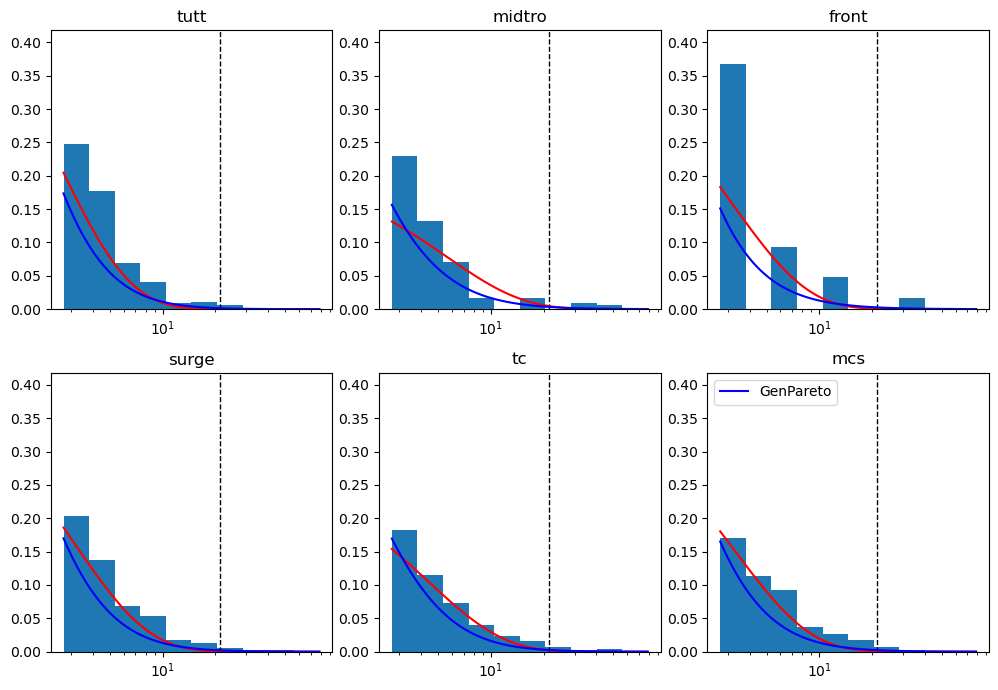

In [10]:
[mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
[param_mcs_ga, param_tc_ga, param_surge_ga, param_front_ga, param_midtro_ga, param_tutt_ga], \
[param_mcs_gp, param_tc_gp, param_surge_gp, param_front_gp, param_midtro_gp, param_tutt_gp], \
two_way_precip = plot_sub(sub_id=1, dis_type='gamma')

15
MCS 0.6176136875270789 1.7556184846264462
TC 0.48775099241445424 2.215495311476203
Surge 0.5386614089478106 1.7756594275175461
Midtro 0.7350503297215603 2.131947066183386
UTT 0.47925229873660363 1.603640554204271


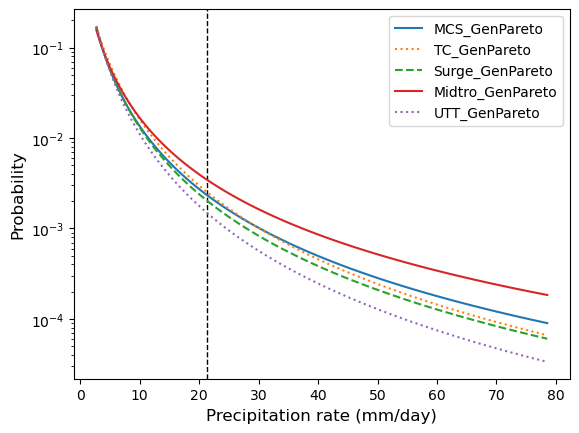

In [11]:
fig = plt.figure()
sub_precip = monsoon_precip.sel(sub_id=1)
sub_precip = sub_precip[sub_precip>1]
plt.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
print(len(two_way_precip))
x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
precip_list = [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip]
for i, precip in enumerate(precip_list):
    if len(precip) > 10:
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(names[i], a1, scale1)
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(names[i], a2, scale2)
        plt.plot(x, pdf, label=names[i]+'_'+dis, linestyle=linestyle_str[i%4])
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precipitation rate (mm/day)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.savefig('Sub1-1.png', dpi=200, bbox_inches='tight')
plt.show()

15
TC_UTT (0.5523972122103883, 2.1323830186090955)
TC_mcs (0.5598832268484022, 2.3405248784092247)
TC_surge (0.5175826035700748, 2.2318466927210974)
TC_midtro (0.6892374343975707, 2.3288501802097192)
UTT_MCS (0.6468679822037275, 1.622097246651416)
UTT_Surge (0.49514729403966884, 1.7733953804490958)
MCS_Surge (0.5118208037020862, 2.1112365892981613)
Midtro_Surge (0.6489184340822199, 2.3550488264236678)


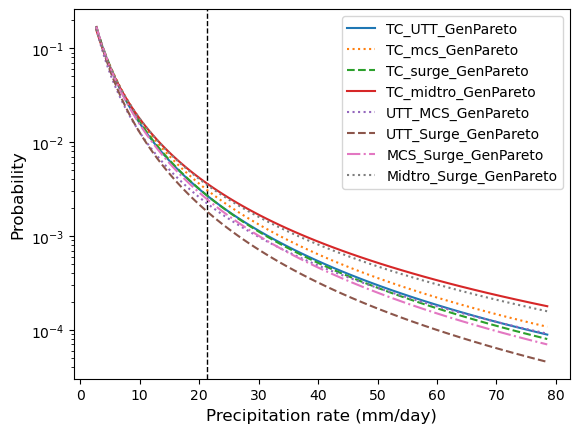

In [12]:
two_way_params_gp = {}
two_way_params_ga = {}

fig = plt.figure()
sub_precip = monsoon_precip.sel(sub_id=1)
sub_precip = sub_precip[sub_precip>1]
plt.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
print(len(two_way_precip))
x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
for i, precip in enumerate(two_way_precip[:]):
    if len(precip) > 10:
        # print(two_way_names[i])
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(two_way_names[i], (a1, scale1))
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(two_way_names[i], (a2, scale2))
        two_way_params_gp[two_way_names[i]] = (a2, scale2)
        two_way_params_ga[two_way_names[i]] = (a1, scale1)
        plt.plot(x, pdf, label=two_way_names[i]+'_'+dis, linestyle=linestyle_str[i%4])


# plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.21))
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precipitation rate (mm/day)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.savefig('Sub1-2.png', dpi=200, bbox_inches='tight')
plt.show()

In [13]:
precip_list = [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip]
CDF_Function(1, two_way_precip, precip_list)

TOTAL:  767
TC_UTT 56
TC_UTT (0.5523972122103883, 2.1323830186090955) 0.035979819556997694 56
TC_mcs 42
TC_mcs (0.5598832268484022, 2.3405248784092247) 0.042362666761290635 42
TC_surge 208
TC_surge (0.5175826035700748, 2.2318466927210974) 0.03437980295804843 208
TC_front 2
TC_midtro 24
TC_midtro (0.6892374343975707, 2.3288501802097192) 0.059083158306387995 24
UTT_MCS 39
UTT_MCS (0.6468679822037275, 1.622097246651416) 0.032800679996216164 39
UTT_Surge 171
UTT_Surge (0.49514729403966884, 1.7733953804490958) 0.02155429174518486 171
UTT_Midtro 7
UTT_Midtro (0.5257150834661869, 2.415214353622588) 0.0399856559436097 7
UTT_Front 3
MCS_Midtro 2
MCS_Front 4
MCS_Front (0.9999999996677302, 6.480519533340298) 0.04318433401478672 4
MCS_Surge 102
MCS_Surge (0.5118208037020862, 2.1112365892981613) 0.030806541515448593 102
Midtro_Front 0
Midtro_Surge 25
Midtro_Surge (0.6489184340822199, 2.3550488264236678) 0.05444294445395481 25
Front_Surge 6
Front_Surge (0.4091109526462265, 2.4193840430783125) 0.0261

In [14]:
def plot(sub_id, save=False):
    fig = plt.figure(figsize=(10, 4))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    sub_precip = monsoon_precip.sel(sub_id=sub_id)
    sub_precip = sub_precip[sub_precip>1]
    threshold = np.quantile(sub_precip, .95)
    ax1.axvline(threshold, color='k', linestyle='dashed', linewidth=1)
    ax2.axvline(threshold, color='k', linestyle='dashed', linewidth=1)
    print(threshold)
    x = np.logspace(1, np.log(threshold*2), num=100, base=np.e)
    min_pdf = 10
    max_pdf = 0
    for i, precip in enumerate(precip_list):
        if len(precip) > 10:
            (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            # print(names[i], a2, scale2)
            ax1.plot(x, pdf, label=names[i], linestyle=linestyle_str[i%4])
            min_pdf = np.min([min_pdf, np.min(pdf)])
            max_pdf = np.max([max_pdf, np.max(pdf)])
    for i, precip in enumerate(two_way_precip[:]):
        if len(precip) > 10:
            # print(two_way_names[i])
            (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            # print(two_way_names[i], (a2, scale2))
            two_way_params_gp[two_way_names[i]] = (a2, scale2)
            two_way_params_ga[two_way_names[i]] = (a1, scale1)
            ax2.plot(x, pdf, label=two_way_names[i], linestyle=linestyle_str[i%4])
            min_pdf = np.min([min_pdf, np.min(pdf)])
            max_pdf = np.max([max_pdf, np.max(pdf)])
    ax1.legend()
    ax2.legend()
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax1.set_ylim([min_pdf, max_pdf+5e-2])
    ax2.set_ylim([min_pdf, max_pdf+5e-2])
    ax1.set_xlabel('Precipitation rate (mm/day)', fontsize=12)
    ax2.set_xlabel('Precipitation rate (mm/day)', fontsize=12)
    ax1.set_ylabel('Probability', fontsize=12)
    plt.tight_layout()
    if save:
        plt.savefig(str(sub_id)+'-GenPareto.png', dpi=200, bbox_inches='tight')
    plt.show()

21.363590636973544


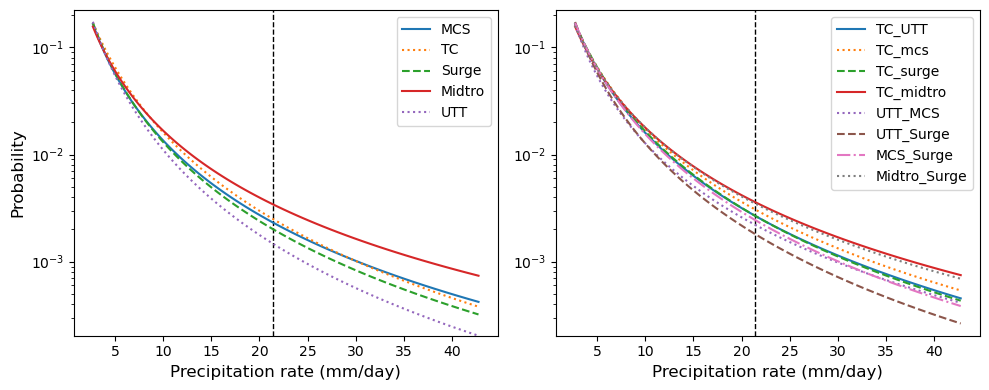

In [15]:
plot(sub_id=1, save=True)

# Sub2

tutt
Midtro
front
surge
tc
mcs


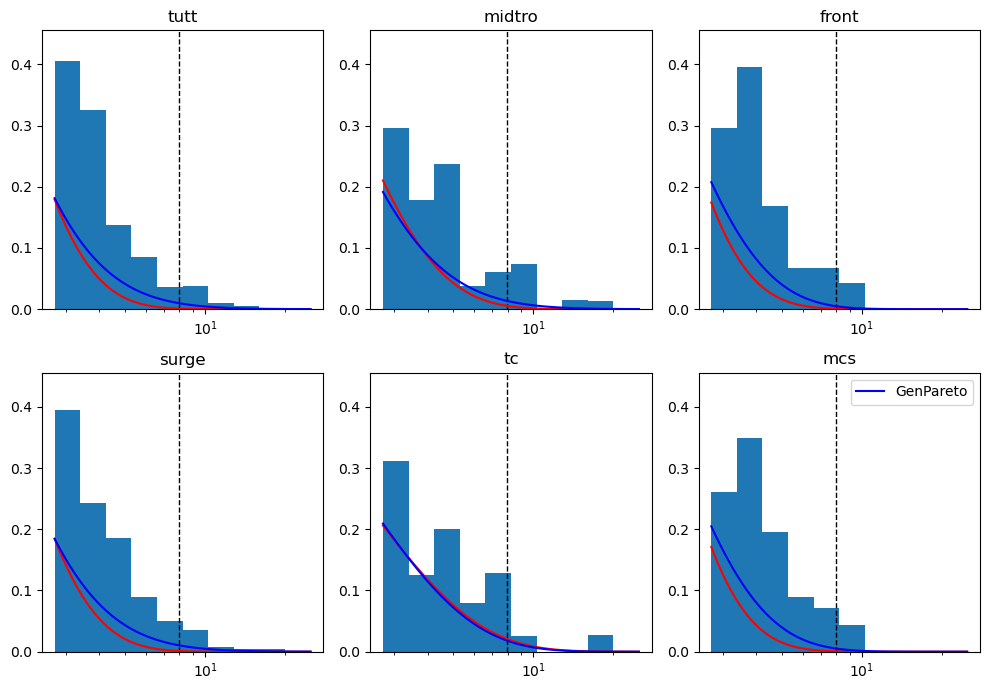

In [16]:
[mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
[param_mcs_ga, param_tc_ga, param_surge_ga, param_front_ga, param_midtro_ga, param_tutt_ga], \
[param_mcs_gp, param_tc_gp, param_surge_gp, param_front_gp, param_midtro_gp, param_tutt_gp], \
two_way_precip = plot_sub(sub_id=2, dis_type='gamma')

15
MCS 0.028925995348516156 1.351894489105376
TC 0.9999999981637224 2.289369120478458
Surge 0.24221777650377863 1.2786692554252292
Front 0.01109071142418543 1.379373110807523
Midtro 0.22271212002451554 1.5024297545129652
UTT 0.2526274543986039 1.222749109960498


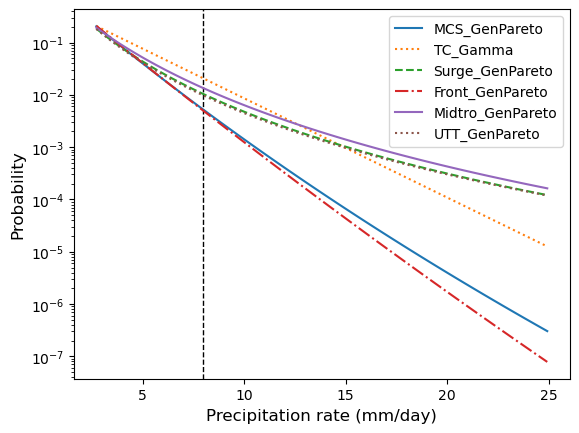

In [17]:
fig = plt.figure()
sub_precip = monsoon_precip.sel(sub_id=2)
sub_precip = sub_precip[sub_precip>1]
plt.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
print(len(two_way_precip))
x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
precip_list = [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip]
for i, precip in enumerate(precip_list):
    if len(precip) > 10:
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(names[i], a1, scale1)
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(names[i], a2, scale2)
        plt.plot(x, pdf, label=names[i]+'_'+dis, linestyle=linestyle_str[i%4])
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precipitation rate (mm/day)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.savefig('Sub2-1.png', dpi=200, bbox_inches='tight')
plt.show()

15
TC_surge (0.9999999981637224, 2.289369120478458)
UTT_MCS (5.149986714969003e-06, 1.34229459700509)
UTT_Surge (0.2135861900138134, 1.2612930392976647)
UTT_Midtro (0.2198328479247139, 1.4233605831409677)
UTT_Front (2.053948319375604e-07, 1.3394965490533655)
MCS_Front (7.959091817614407e-07, 1.5121143414158722)
MCS_Surge (0.10182070300642292, 1.377368216735095)
Midtro_Surge (0.9999999979258342, 2.009073619205761)
Front_Surge (1.7307300996128447e-07, 1.4551059491870484)


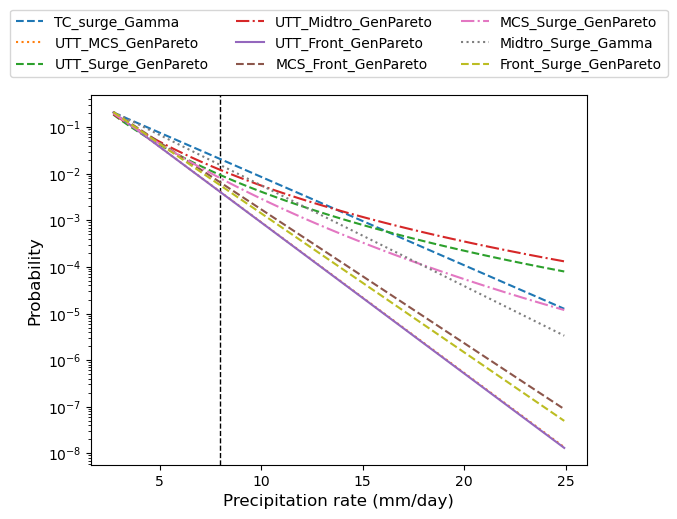

In [18]:
fig = plt.figure()
sub_precip = monsoon_precip.sel(sub_id=2)
sub_precip = sub_precip[sub_precip>1]
plt.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
print(len(two_way_precip))
x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
for i, precip in enumerate(two_way_precip[:]):
    if len(precip) > 10:
        # print(two_way_names[i])
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(two_way_names[i], (a1, scale1))
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(two_way_names[i], (a2, scale2))
        two_way_params_gp[two_way_names[i]] = (a2, scale2)
        two_way_params_ga[two_way_names[i]] = (a1, scale1)
        plt.plot(x, pdf, label=two_way_names[i]+'_'+dis, linestyle=linestyle_str[i%4])


plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.25))
# plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precipitation rate (mm/day)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.savefig('Sub2-2.png', dpi=200, bbox_inches='tight')
plt.show()

In [19]:
precip_list = [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip]
CDF_Function(2, two_way_precip, precip_list)

TOTAL:  761
TC_UTT 3
TC_mcs 3
TC_surge 23
TC_surge (0.9999999981637224, 2.289369120478458) 0.0473390999736335 23
TC_front 7
TC_front (1.0787769908010947e-07, 1.787825420092247) 0.02011759635139132 7
TC_midtro 5
TC_midtro (0.9999999985425012, 3.2033020920049) 0.11302968168499972 5
UTT_MCS 46
UTT_MCS (5.149986714969003e-06, 1.34229459700509) 0.005502162449117387 46
UTT_Surge 204
UTT_Surge (0.2135861900138134, 1.2612930392976647) 0.025879360195548595 204
UTT_Midtro 17
UTT_Midtro (0.2198328479247139, 1.4233605831409677) 0.035851400299613534 17
UTT_Front 45
UTT_Front (2.053948319375604e-07, 1.3394965490533655) 0.0054423257486326815 45
MCS_Midtro 1
MCS_Front 38
MCS_Front (7.959091817614407e-07, 1.5121143414158722) 0.009868751769919526 38
MCS_Surge 65
MCS_Surge (0.10182070300642292, 1.377368216735095) 0.016773054985624647 65
Midtro_Front 6
Midtro_Front (0.16811711362910958, 1.3583765267728265) 0.024598106183788326 6
Midtro_Surge 27
Midtro_Surge (0.9999999979258342, 2.009073619205761) 0.030930

15
TC_surge (0.9999999981637224, 2.289369120478458)
UTT_MCS (5.149986714969003e-06, 1.34229459700509)
UTT_Surge (0.2135861900138134, 1.2612930392976647)
UTT_Midtro (0.2198328479247139, 1.4233605831409677)
UTT_Front (2.053948319375604e-07, 1.3394965490533655)
MCS_Front (7.959091817614407e-07, 1.5121143414158722)
MCS_Surge (0.10182070300642292, 1.377368216735095)
Midtro_Surge (0.9999999979258342, 2.009073619205761)
Front_Surge (1.7307300996128447e-07, 1.4551059491870484)
0
MCS 0.028925995348516156 1.351894489105376
1
TC 0.9999999981637224 2.289369120478458
2
Surge 0.24221777650377863 1.2786692554252292
3
Front 0.01109071142418543 1.379373110807523
4
Midtro 0.22271212002451554 1.5024297545129652
5
UTT 0.2526274543986039 1.222749109960498


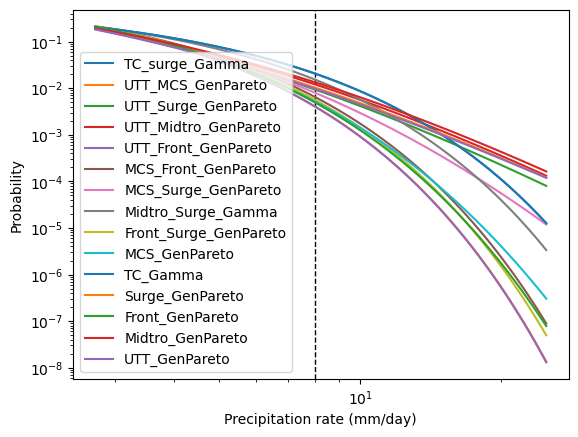

In [20]:
two_way_params_gp = {}
two_way_params_ga = {}
fig = plt.figure()
sub_precip = monsoon_precip.sel(sub_id=2)
sub_precip = sub_precip[sub_precip>1]
plt.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
print(len(two_way_precip))
x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
for i, precip in enumerate(two_way_precip[:]):
    if len(precip) > 10:
        # print(two_way_names[i])
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(two_way_names[i], (a1, scale1))
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(two_way_names[i], (a2, scale2))
        two_way_params_gp[two_way_names[i]] = (a2, scale2)
        two_way_params_ga[two_way_names[i]] = (a1, scale1)
        plt.plot(x, pdf, label=two_way_names[i]+'_'+dis)
precip_list = [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip]
for i, precip in enumerate(precip_list):
    if len(precip) > 10:
        print(i)
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(names[i], a1, scale1)
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(names[i], a2, scale2)
        plt.plot(x, pdf, label=names[i]+'_'+dis)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precipitation rate (mm/day)')
plt.ylabel('Probability')
plt.show()

7.98353434112839


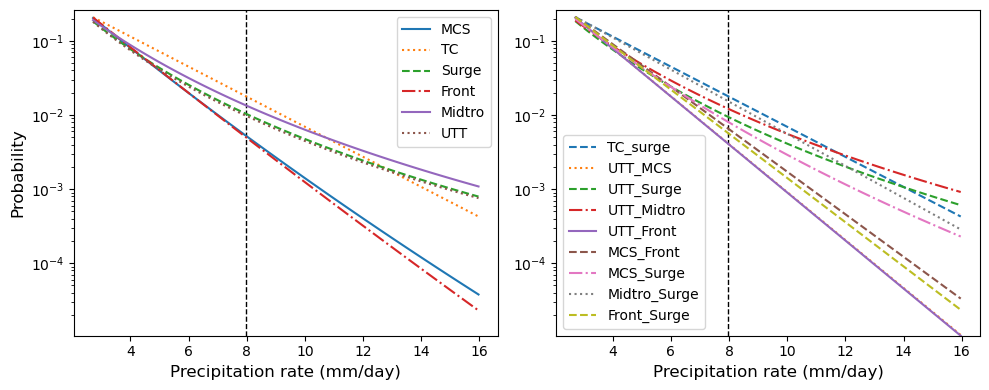

In [21]:
plot(sub_id=2, save=True)

In [22]:
print(names)

['MCS', 'TC', 'Surge', 'Front', 'Midtro', 'UTT']


# Sub3

tutt
Midtro
front
surge
mcs


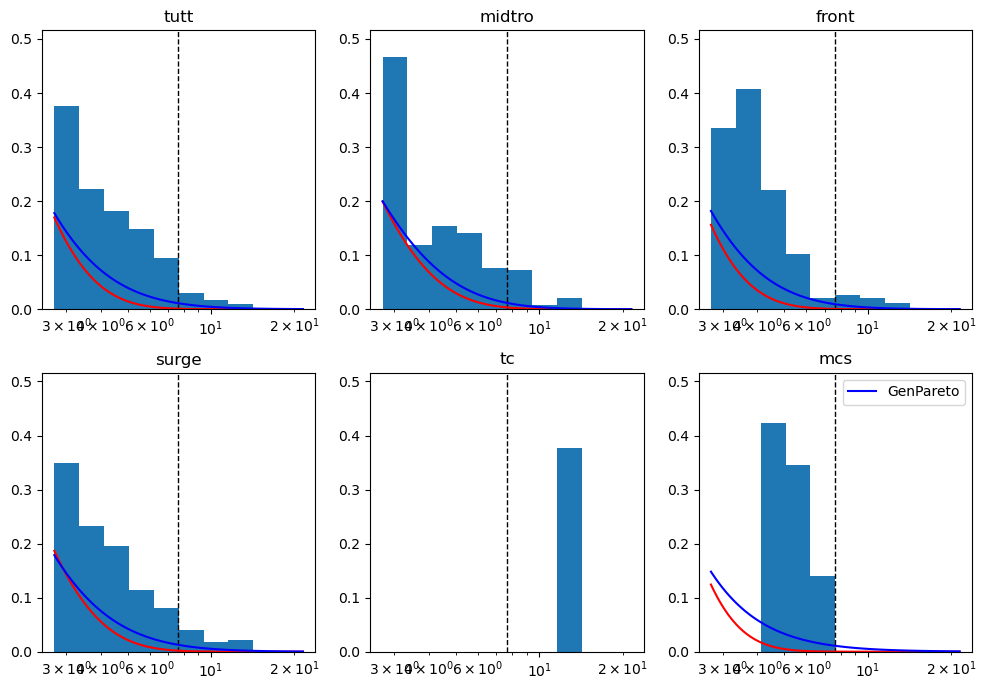

In [23]:
[mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
[param_mcs_ga, param_tc_ga, param_surge_ga, param_front_ga, param_midtro_ga, param_tutt_ga], \
[param_mcs_gp, param_tc_gp, param_surge_gp, param_front_gp, param_midtro_gp, param_tutt_gp], \
two_way_precip = plot_sub(sub_id=3, dis_type='gamma')

15
UTT_MCS (0.8047259475720125, 0.7063050465818788)
UTT_Surge (0.22284344736495595, 1.2846477591137646)
UTT_Midtro (0.11223533314910433, 1.4408401374375361)
UTT_Front (0.2928512984200289, 1.1446754993163386)
MCS_Front (0.23317183284097054, 0.9627494812788526)
MCS_Surge (0.41173544594302547, 0.9002759159122246)
Midtro_Front (0.3509505784978657, 1.247326788325548)
Midtro_Surge (2.431068242051027e-08, 1.7726469021265094)
Front_Surge (0.2442890082802966, 1.2020402983273821)
MCS 0.5094011840211217 0.8951657311709296
Surge 0.2981780127563388 1.2343290025635012
Front 0.20533998643173268 1.1675306640087473
Midtro 0.11733212486716019 1.45708731684216
UTT 0.27054929053359045 1.174586843414057


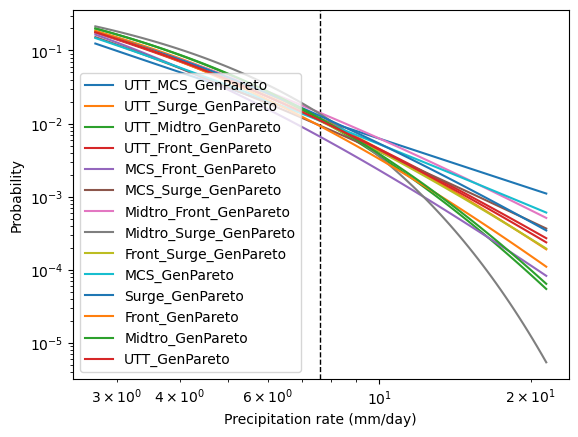

In [24]:
two_way_params_gp = {}
two_way_params_ga = {}
fig = plt.figure()
sub_precip = monsoon_precip.sel(sub_id=3)
sub_precip = sub_precip[sub_precip>1]
plt.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
print(len(two_way_precip))
x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
for i, precip in enumerate(two_way_precip[:]):
    if len(precip) > 10:
        # print(two_way_names[i])
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(two_way_names[i], (a1, scale1))
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(two_way_names[i], (a2, scale2))
        two_way_params_gp[two_way_names[i]] = (a2, scale2)
        two_way_params_ga[two_way_names[i]] = (a1, scale1)
        plt.plot(x, pdf, label=two_way_names[i]+'_'+dis)
precip_list = [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip]
for i, precip in enumerate(precip_list):
    if len(precip) > 10:
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(names[i], a1, scale1)
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(names[i], a2, scale2)
        plt.plot(x, pdf, label=names[i]+'_'+dis)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precipitation rate (mm/day)')
plt.ylabel('Probability')
plt.show()

15
MCS 0.5094011840211217 0.8951657311709296
Surge 0.2981780127563388 1.2343290025635012
Front 0.20533998643173268 1.1675306640087473
Midtro 0.11733212486716019 1.45708731684216
UTT 0.27054929053359045 1.174586843414057


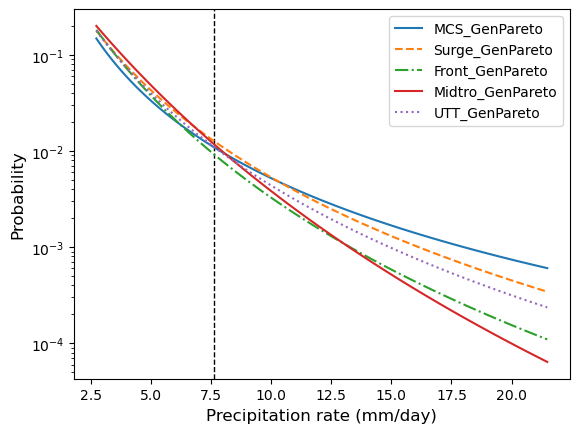

In [25]:
fig = plt.figure()
sub_precip = monsoon_precip.sel(sub_id=3)
sub_precip = sub_precip[sub_precip>1]
plt.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
print(len(two_way_precip))
x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
precip_list = [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip]
for i, precip in enumerate(precip_list):
    if len(precip) > 10:
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(names[i], a1, scale1)
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(names[i], a2, scale2)
        plt.plot(x, pdf, label=names[i]+'_'+dis, linestyle=linestyle_str[i%4])
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precipitation rate (mm/day)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.savefig('Sub3-1.png', dpi=200, bbox_inches='tight')
plt.show()

15
UTT_MCS (0.8047259475720125, 0.7063050465818788)
UTT_Surge (0.22284344736495595, 1.2846477591137646)
UTT_Midtro (0.11223533314910433, 1.4408401374375361)
UTT_Front (0.2928512984200289, 1.1446754993163386)
MCS_Front (0.23317183284097054, 0.9627494812788526)
MCS_Surge (0.41173544594302547, 0.9002759159122246)
Midtro_Front (0.3509505784978657, 1.247326788325548)
Midtro_Surge (2.431068242051027e-08, 1.7726469021265094)
Front_Surge (0.2442890082802966, 1.2020402983273821)


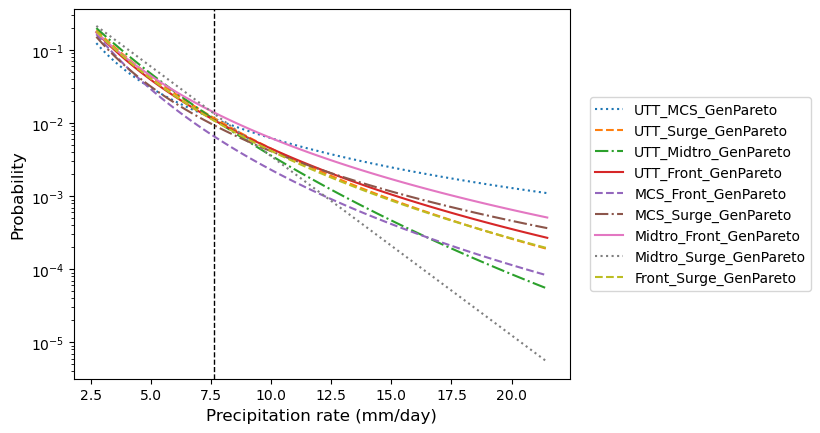

In [26]:
fig = plt.figure()
sub_precip = monsoon_precip.sel(sub_id=3)
sub_precip = sub_precip[sub_precip>1]
plt.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
print(len(two_way_precip))
x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
for i, precip in enumerate(two_way_precip[:]):
    if len(precip) > 10:
        # print(two_way_names[i])
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(two_way_names[i], (a1, scale1))
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(two_way_names[i], (a2, scale2))
        two_way_params_gp[two_way_names[i]] = (a2, scale2)
        two_way_params_ga[two_way_names[i]] = (a1, scale1)
        plt.plot(x, pdf, label=two_way_names[i]+'_'+dis, linestyle=linestyle_str[i%4])


plt.legend(loc='right', ncol=1, bbox_to_anchor=(1.5, 0.5))
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precipitation rate (mm/day)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.savefig('Sub3-2.png', dpi=200, bbox_inches='tight')
plt.show()

In [27]:
precip_list = [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip]
CDF_Function(3, two_way_precip, precip_list)

TOTAL:  728
TC_UTT 0
TC_mcs 0
TC_surge 1
TC_front 0
TC_midtro 0
UTT_MCS 14
UTT_MCS (0.8047259475720125, 0.7063050465818788) 0.06943362670882647 14
UTT_Surge 201
UTT_Surge (0.22284344736495595, 1.2846477591137646) 0.032208342565892445 201
UTT_Midtro 60
UTT_Midtro (0.11223533314910433, 1.4408401374375361) 0.024471344909724912 60
UTT_Front 80
UTT_Front (0.2928512984200289, 1.1446754993163386) 0.03380414343215321 80
MCS_Midtro 5
MCS_Midtro (0.2532181944443182, 1.0844211766233922) 0.024865897873109888 5
MCS_Front 12
MCS_Front (0.23317183284097054, 0.9627494812788526) 0.016444924594808508 12
MCS_Surge 14
MCS_Surge (0.41173544594302547, 0.9002759159122246) 0.03382047991706583 14
Midtro_Front 27
Midtro_Front (0.3509505784978657, 1.247326788325548) 0.04979233722040377 27
Midtro_Surge 61
Midtro_Surge (2.431068242051027e-08, 1.7726469021265094) 0.02373701838948017 61
Front_Surge 127
Front_Surge (0.2442890082802966, 1.2020402983273821) 0.030397840563727185 127
MCS 22
MCS 0.5094011840211217 0.89516

7.6309751208430425


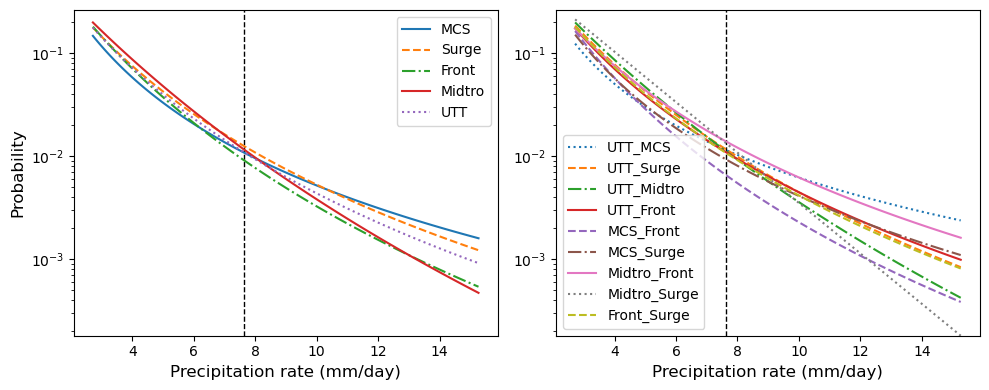

In [28]:
plot(sub_id=3, save=True)

# Sub4

tutt
Midtro
front
surge
mcs


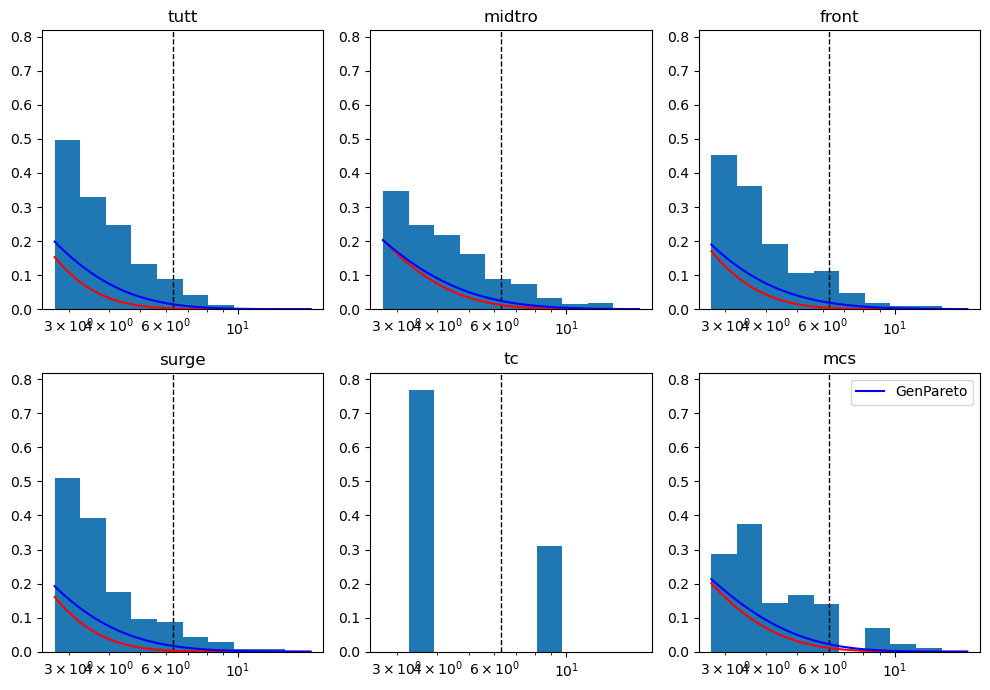

In [29]:
[mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
[param_mcs_ga, param_tc_ga, param_surge_ga, param_front_ga, param_midtro_ga, param_tutt_ga], \
[param_mcs_gp, param_tc_gp, param_surge_gp, param_front_gp, param_midtro_gp, param_tutt_gp], \
two_way_precip = plot_sub(sub_id=4, dis_type='gamma')

15
UTT_MCS (1.5025894950324427e-07, 1.4501574826881032)
UTT_Surge (0.03564502331169375, 1.2650512920708716)
UTT_Midtro (1.720564439891938e-06, 1.515044058486819)
UTT_Front (0.0753863581310971, 1.2524795700976674)
MCS_Midtro (0.9999999945826541, 2.1861672715450107)
MCS_Front (0.020680359569168787, 1.5301659319485257)
MCS_Surge (0.0663592252403123, 1.579183335374358)
Midtro_Front (0.16036850334737518, 1.68649193722274)
Midtro_Surge (0.0780661173863427, 1.761919034494119)
Front_Surge (0.26861865890460035, 1.1705007740550095)
MCS 0.0009736012787325315 1.56375154957641
Surge 0.11614039813507086 1.2441918957253773
Front 0.1600538575788013 1.2564639612584023
Midtro 0.1006082653328467 1.51680611323428
UTT 0.05122860866242967 1.2579719091600543


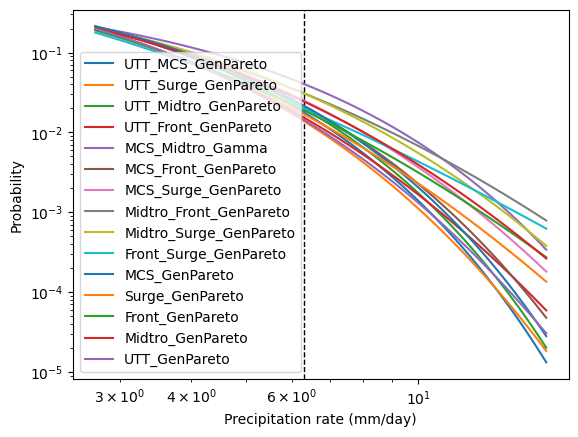

In [30]:
two_way_params_gp = {}
two_way_params_ga = {}
fig = plt.figure()
sub_precip = monsoon_precip.sel(sub_id=4)
sub_precip = sub_precip[sub_precip>1]
plt.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
print(len(two_way_precip))
x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
for i, precip in enumerate(two_way_precip[:]):
    if len(precip) > 10:
        # print(two_way_names[i])
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(two_way_names[i], (a1, scale1))
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(two_way_names[i], (a2, scale2))
        two_way_params_gp[two_way_names[i]] = (a2, scale2)
        two_way_params_ga[two_way_names[i]] = (a1, scale1)
        plt.plot(x, pdf, label=two_way_names[i]+'_'+dis)
precip_list = [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip]
for i, precip in enumerate(precip_list):
    if len(precip) > 10:
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(names[i], a1, scale1)
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(names[i], a2, scale2)
        plt.plot(x, pdf, label=names[i]+'_'+dis)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precipitation rate (mm/day)')
plt.ylabel('Probability')
plt.show()

15
MCS 0.0009736012787325315 1.56375154957641
Surge 0.11614039813507086 1.2441918957253773
Front 0.1600538575788013 1.2564639612584023
Midtro 0.1006082653328467 1.51680611323428
UTT 0.05122860866242967 1.2579719091600543


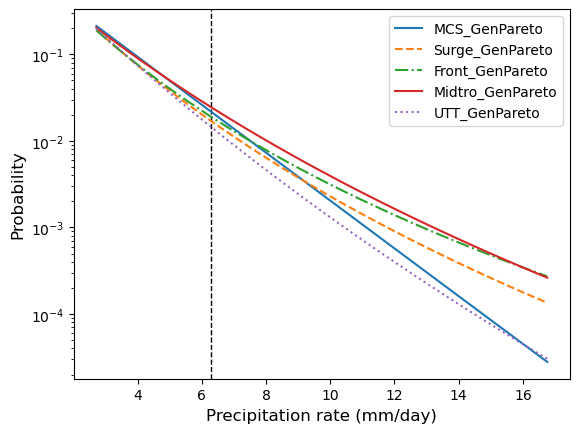

In [31]:
fig = plt.figure()
sub_precip = monsoon_precip.sel(sub_id=4)
sub_precip = sub_precip[sub_precip>1]
plt.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
print(len(two_way_precip))
x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
precip_list = [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip]
for i, precip in enumerate(precip_list):
    if len(precip) > 10:
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(names[i], a1, scale1)
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(names[i], a2, scale2)
        plt.plot(x, pdf, label=names[i]+'_'+dis, linestyle=linestyle_str[i%4])
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precipitation rate (mm/day)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.savefig('Sub4-1.png', dpi=200, bbox_inches='tight')
plt.show()

15
UTT_MCS (1.5025894950324427e-07, 1.4501574826881032)
UTT_Surge (0.03564502331169375, 1.2650512920708716)
UTT_Midtro (1.720564439891938e-06, 1.515044058486819)
UTT_Front (0.0753863581310971, 1.2524795700976674)
MCS_Midtro (0.9999999945826541, 2.1861672715450107)
MCS_Front (0.020680359569168787, 1.5301659319485257)
MCS_Surge (0.0663592252403123, 1.579183335374358)
Midtro_Front (0.16036850334737518, 1.68649193722274)
Midtro_Surge (0.0780661173863427, 1.761919034494119)
Front_Surge (0.26861865890460035, 1.1705007740550095)


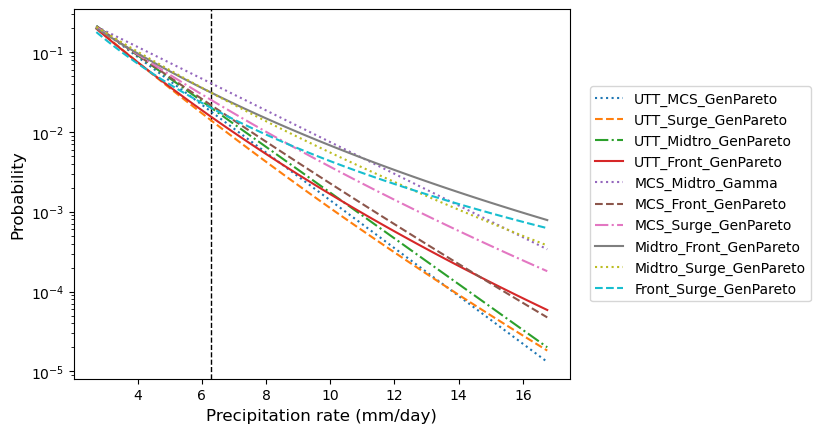

In [32]:
fig = plt.figure()
sub_precip = monsoon_precip.sel(sub_id=4)
sub_precip = sub_precip[sub_precip>1]
plt.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
print(len(two_way_precip))
x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
for i, precip in enumerate(two_way_precip[:]):
    if len(precip) > 10:
        # print(two_way_names[i])
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(two_way_names[i], (a1, scale1))
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(two_way_names[i], (a2, scale2))
        two_way_params_gp[two_way_names[i]] = (a2, scale2)
        two_way_params_ga[two_way_names[i]] = (a1, scale1)
        plt.plot(x, pdf, label=two_way_names[i]+'_'+dis, linestyle=linestyle_str[i%4])


plt.legend(loc='right', ncol=1, bbox_to_anchor=(1.5, 0.5))
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precipitation rate (mm/day)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.savefig('Sub4-2.png', dpi=200, bbox_inches='tight')
plt.show()

In [33]:
precip_list = [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip]
CDF_Function(4, two_way_precip, precip_list)

TOTAL:  1531
TC_UTT 0
TC_mcs 0
TC_surge 2
TC_front 0
TC_midtro 1
UTT_MCS 56
UTT_MCS (1.5025894950324427e-07, 1.4501574826881032) 0.025922778951683045 56
UTT_Surge 394
UTT_Surge (0.03564502331169375, 1.2650512920708716) 0.02018899779413852 394
UTT_Midtro 105
UTT_Midtro (1.720564439891938e-06, 1.515044058486819) 0.030312714877144153 105
UTT_Front 287
UTT_Front (0.0753863581310971, 1.2524795700976674) 0.025453399844720503 287
MCS_Midtro 15
MCS_Midtro (0.9999999945826541, 2.1861672715450107) 0.08866289545181205 15
MCS_Front 83
MCS_Front (0.020680359569168787, 1.5301659319485257) 0.035318298409115045 83
MCS_Surge 48
MCS_Surge (0.0663592252403123, 1.579183335374358) 0.04839098891709537 48
Midtro_Front 70
Midtro_Front (0.16036850334737518, 1.68649193722274) 0.07858140841484451 70
Midtro_Surge 87
Midtro_Surge (0.0780661173863427, 1.761919034494119) 0.06716859426007615 87
Front_Surge 287
Front_Surge (0.26861865890460035, 1.1705007740550095) 0.05174068163338963 287
MCS 98
MCS 0.00097360127873253

6.2968948209451305


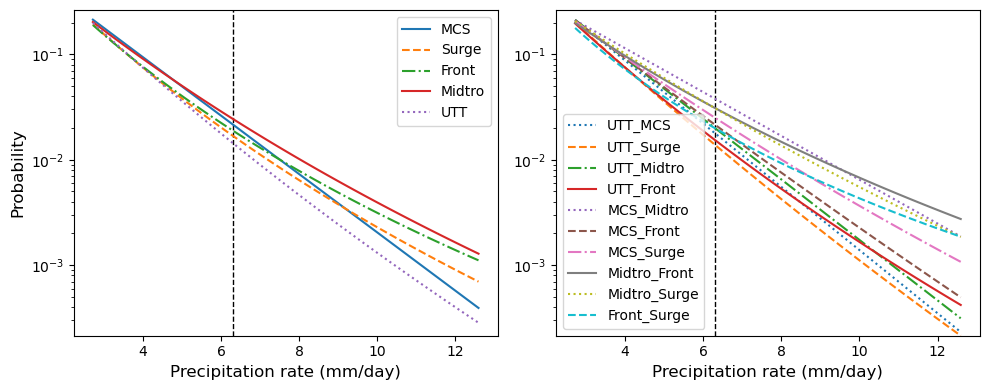

In [34]:
plot(sub_id=4, save=True)

# Sub5

tutt
Midtro
front
surge
tc
mcs


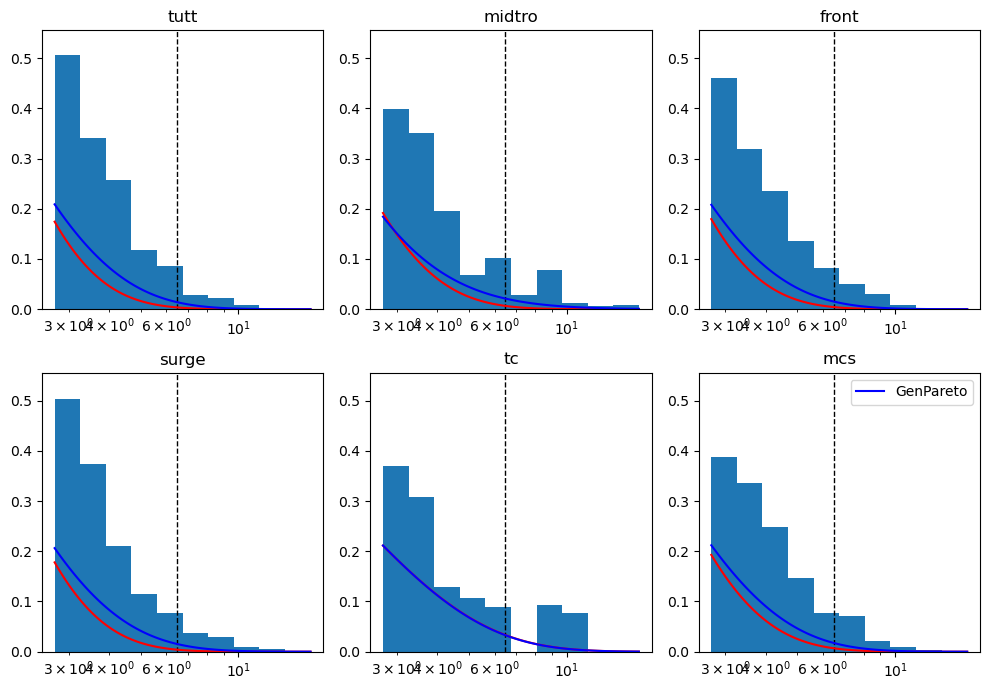

In [35]:
[mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
[param_mcs_ga, param_tc_ga, param_surge_ga, param_front_ga, param_midtro_ga, param_tutt_ga], \
[param_mcs_gp, param_tc_gp, param_surge_gp, param_front_gp, param_midtro_gp, param_tutt_gp], \
two_way_precip = plot_sub(sub_id=5, dis_type='gamma')

15
TC_surge (0.9999999981224679, 2.0969709318109033)
TC_front (7.155346775795532e-08, 1.906125798468253)
UTT_MCS (2.2060234186944118e-07, 1.4977391210282804)
UTT_Surge (0.0009922799519263207, 1.423808103147894)
UTT_Midtro (0.13601059300898613, 1.360748584639869)
UTT_Front (2.4802466817142586e-06, 1.452981851734209)
MCS_Midtro (2.601896093199476e-07, 1.896779295535385)
MCS_Front (8.052264033281055e-08, 1.5096327382916153)
MCS_Surge (2.5222077965754573e-07, 1.5383128628134735)
Midtro_Front (0.07700093390670343, 1.5893443757092691)
Midtro_Surge (0.17408284903327997, 1.5999040416246206)
Front_Surge (0.0358433744145293, 1.4095682510885186)
MCS 1.6808509826660048e-06 1.4999274253845227
TC 0.999999979717588 2.0288313144330408
Surge 0.02669216042135992 1.3874078799002434
Front 0.015071530936088234 1.4041190548385512
Midtro 0.2526491900095606 1.2971610778252791
UTT 3.1279027462010845e-07 1.3874322950839995


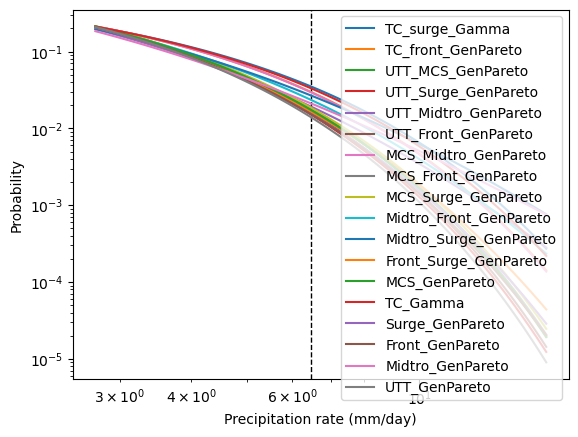

In [36]:
two_way_params_gp = {}
two_way_params_ga = {}
fig = plt.figure()
sub_precip = monsoon_precip.sel(sub_id=5)
sub_precip = sub_precip[sub_precip>1]
plt.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
print(len(two_way_precip))
x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
for i, precip in enumerate(two_way_precip[:]):
    if len(precip) > 10:
        # print(two_way_names[i])
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(two_way_names[i], (a1, scale1))
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(two_way_names[i], (a2, scale2))
        two_way_params_gp[two_way_names[i]] = (a2, scale2)
        two_way_params_ga[two_way_names[i]] = (a1, scale1)
        plt.plot(x, pdf, label=two_way_names[i]+'_'+dis)
precip_list = [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip]
for i, precip in enumerate(precip_list):
    if len(precip) > 10:
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(names[i], a1, scale1)
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(names[i], a2, scale2)
        plt.plot(x, pdf, label=names[i]+'_'+dis)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precipitation rate (mm/day)')
plt.ylabel('Probability')
plt.show()

15
MCS 1.6808509826660048e-06 1.4999274253845227
TC 0.999999979717588 2.0288313144330408
Surge 0.02669216042135992 1.3874078799002434
Front 0.015071530936088234 1.4041190548385512
Midtro 0.2526491900095606 1.2971610778252791
UTT 3.1279027462010845e-07 1.3874322950839995


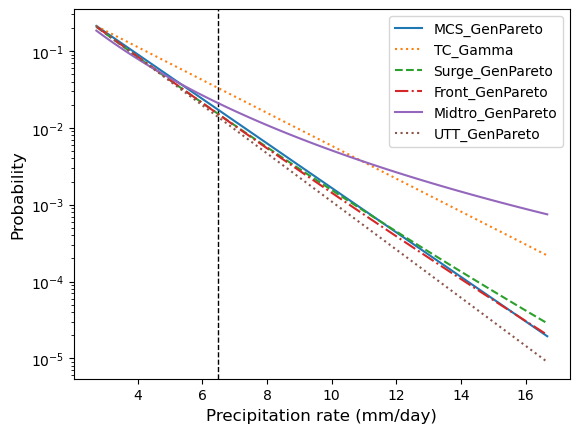

In [37]:
fig = plt.figure()
sub_precip = monsoon_precip.sel(sub_id=5)
sub_precip = sub_precip[sub_precip>1]
plt.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
print(len(two_way_precip))
x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
precip_list = [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip]
for i, precip in enumerate(precip_list):
    if len(precip) > 10:
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(names[i], a1, scale1)
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(names[i], a2, scale2)
        plt.plot(x, pdf, label=names[i]+'_'+dis, linestyle=linestyle_str[i%4])
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precipitation rate (mm/day)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.savefig('Sub5-1.png', dpi=200, bbox_inches='tight')
plt.show()

15
TC_surge (0.9999999981224679, 2.0969709318109033)
TC_front (7.155346775795532e-08, 1.906125798468253)
UTT_MCS (2.2060234186944118e-07, 1.4977391210282804)
UTT_Surge (0.0009922799519263207, 1.423808103147894)
UTT_Midtro (0.13601059300898613, 1.360748584639869)
UTT_Front (2.4802466817142586e-06, 1.452981851734209)
MCS_Midtro (2.601896093199476e-07, 1.896779295535385)
MCS_Front (8.052264033281055e-08, 1.5096327382916153)
MCS_Surge (2.5222077965754573e-07, 1.5383128628134735)
Midtro_Front (0.07700093390670343, 1.5893443757092691)
Midtro_Surge (0.17408284903327997, 1.5999040416246206)
Front_Surge (0.0358433744145293, 1.4095682510885186)


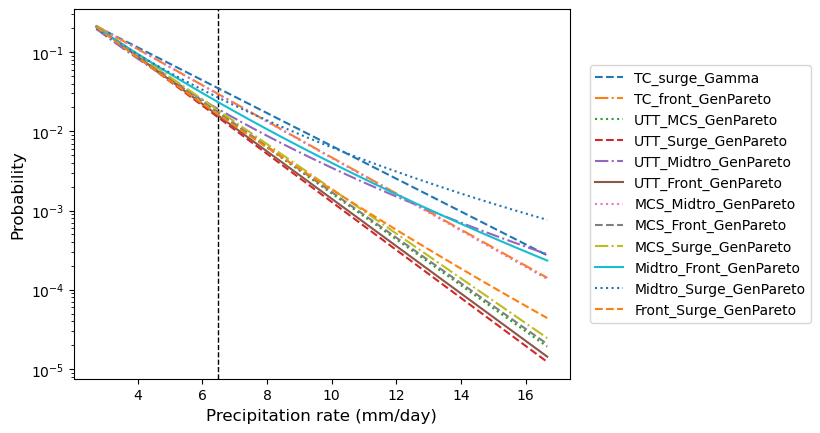

In [38]:
fig = plt.figure()
sub_precip = monsoon_precip.sel(sub_id=5)
sub_precip = sub_precip[sub_precip>1]
plt.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
print(len(two_way_precip))
x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
for i, precip in enumerate(two_way_precip[:]):
    if len(precip) > 10:
        # print(two_way_names[i])
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(two_way_names[i], (a1, scale1))
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(two_way_names[i], (a2, scale2))
        two_way_params_gp[two_way_names[i]] = (a2, scale2)
        two_way_params_ga[two_way_names[i]] = (a1, scale1)
        plt.plot(x, pdf, label=two_way_names[i]+'_'+dis, linestyle=linestyle_str[i%4])


plt.legend(loc='right', ncol=1, bbox_to_anchor=(1.5, 0.5))
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precipitation rate (mm/day)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.savefig('Sub5-2.png', dpi=200, bbox_inches='tight')
plt.show()

In [39]:
for i, precip in enumerate(two_way_precip[:]):
    if len(precip) > 5:
        # print(two_way_names[i])
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(two_way_names[i], (a1, scale1), dis)
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(two_way_names[i], (a2, scale2), dis)
        two_way_params_gp[two_way_names[i]] = (a2, scale2)
        two_way_params_ga[two_way_names[i]] = (a1, scale1)
        plt.plot(x, pdf, label=two_way_names[i]+'_'+dis)

TC_UTT (1.1947628021733406e-08, 1.8125162185369705) GenPareto
TC_surge (0.9999999981224679, 2.0969709318109033) Gamma
TC_front (7.155346775795532e-08, 1.906125798468253) GenPareto
TC_midtro (0.9999999986359277, 3.1271845014384936) Gamma
UTT_MCS (2.2060234186944118e-07, 1.4977391210282804) GenPareto
UTT_Surge (0.0009922799519263207, 1.423808103147894) GenPareto
UTT_Midtro (0.13601059300898613, 1.360748584639869) GenPareto
UTT_Front (2.4802466817142586e-06, 1.452981851734209) GenPareto
MCS_Midtro (2.601896093199476e-07, 1.896779295535385) GenPareto
MCS_Front (8.052264033281055e-08, 1.5096327382916153) GenPareto
MCS_Surge (2.5222077965754573e-07, 1.5383128628134735) GenPareto
Midtro_Front (0.07700093390670343, 1.5893443757092691) GenPareto
Midtro_Surge (0.17408284903327997, 1.5999040416246206) GenPareto
Front_Surge (0.0358433744145293, 1.4095682510885186) GenPareto


In [40]:
print(gamma.cdf(1, 0.00025, 0, 0.017182667199817783))
x = np.linspace(0, 10, 100)
cdf = gamma.cdf(x, 0.00025, 0, 0.017182667199817783)

plt.plot(x, cdf)


1.0


In [41]:
precip_list = [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip]
CDF_Function(5, two_way_precip, precip_list)

TOTAL:  2353
TC_UTT 10
TC_UTT (1.1947628021733406e-08, 1.8125162185369705) 0.04891648425698403 10
TC_mcs 3
TC_surge 28
TC_surge (0.9999999981224679, 2.0969709318109033) 0.07365987721403833 28
TC_front 15
TC_front (7.155346775795532e-08, 1.906125798468253) 0.05673042239096615 15
TC_midtro 8
TC_midtro (0.9999999986359277, 3.1271845014384936) 0.17394350067519138 8
UTT_MCS 279
UTT_MCS (2.2060234186944118e-07, 1.4977391210282804) 0.025943050722338268 279
UTT_Surge 705
UTT_Surge (0.0009922799519263207, 1.423808103147894) 0.021619233346867106 705
UTT_Midtro 84
UTT_Midtro (0.13601059300898613, 1.360748584639869) 0.04049757958772915 84
UTT_Front 423
UTT_Front (2.4802466817142586e-06, 1.452981851734209) 0.02318322985068999 423
MCS_Midtro 21
MCS_Midtro (2.601896093199476e-07, 1.896779295535385) 0.055933977841403526 21
MCS_Front 391
MCS_Front (8.052264033281055e-08, 1.5096327382916153) 0.02670027596986113 391
MCS_Surge 270
MCS_Surge (2.5222077965754573e-07, 1.5383128628134735) 0.028566173727066935

6.469523059079158


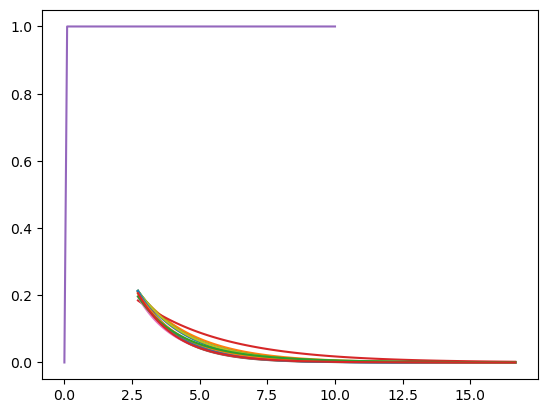

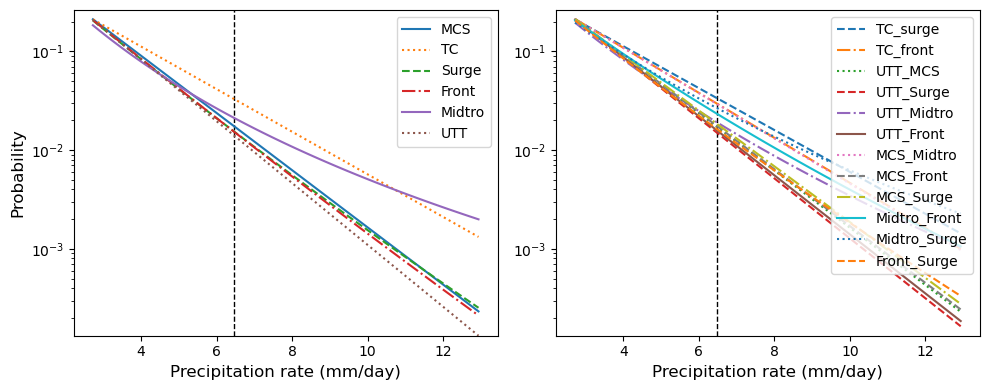

In [42]:
plot(sub_id=5, save=True)

# Sub6

tutt
Midtro
front
surge
tc
mcs


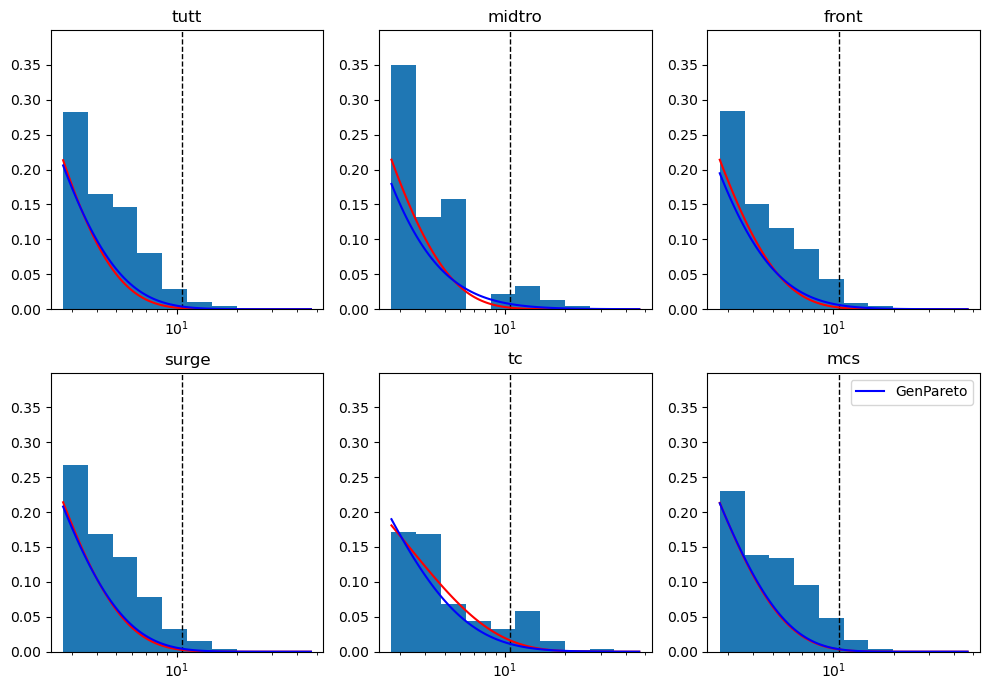

In [43]:
[mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
[param_mcs_ga, param_tc_ga, param_surge_ga, param_front_ga, param_midtro_ga, param_tutt_ga], \
[param_mcs_gp, param_tc_gp, param_surge_gp, param_front_gp, param_midtro_gp, param_tutt_gp], \
two_way_precip = plot_sub(sub_id=6, dis_type='gamma')

15
TC_UTT (0.2736511341348577, 2.0567452998101015)
TC_mcs (0.9999999981236698, 4.250363970399654)
TC_surge (0.9999999999293336, 3.4543298569805856)
TC_front (0.9999999999579148, 7.00528345362479)
UTT_MCS (0.0003889466812997926, 1.929113511387186)
UTT_Surge (0.04979921319440611, 1.8496957287625366)
UTT_Midtro (0.4899096257211762, 1.5231357330425874)
UTT_Front (0.2676046503351848, 1.5401023542412036)
MCS_Front (0.010087295225987909, 1.8655007789374594)
MCS_Surge (0.9999999986611183, 2.0554403481337005)
Midtro_Front (0.21754308865175093, 1.7635282488395658)
Midtro_Surge (0.2789712717011881, 1.841751735696278)
Front_Surge (0.208450350590249, 1.8258285580204014)
MCS 5.4103024186515675e-08 1.946890811512631
TC 0.180596271243681 2.3210678612427067
Surge 0.057057521226791016 1.8382435659356566
Front 0.20280063545934351 1.6801578290928494
Midtro 0.3807538021225876 1.4943055820851863
UTT 0.08100671362737424 1.7029489812759842


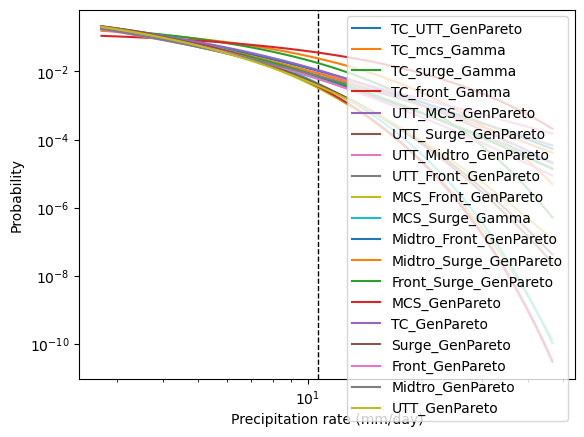

In [44]:
two_way_params_gp = {}
two_way_params_ga = {}
fig = plt.figure()
sub_precip = monsoon_precip.sel(sub_id=6)
sub_precip = sub_precip[sub_precip>1]
plt.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
print(len(two_way_precip))
x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
for i, precip in enumerate(two_way_precip[:]):
    if len(precip) > 10:
        # print(two_way_names[i])
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(two_way_names[i], (a1, scale1))
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(two_way_names[i], (a2, scale2))
        two_way_params_gp[two_way_names[i]] = (a2, scale2)
        two_way_params_ga[two_way_names[i]] = (a1, scale1)
        plt.plot(x, pdf, label=two_way_names[i]+'_'+dis)
precip_list = [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip]
for i, precip in enumerate(precip_list):
    if len(precip) > 10:
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(names[i], a1, scale1)
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(names[i], a2, scale2)
        plt.plot(x, pdf, label=names[i]+'_'+dis)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precipitation rate (mm/day)')
plt.ylabel('Probability')
plt.show()

15
MCS 5.4103024186515675e-08 1.946890811512631
TC 0.180596271243681 2.3210678612427067
Surge 0.057057521226791016 1.8382435659356566
Front 0.20280063545934351 1.6801578290928494
Midtro 0.3807538021225876 1.4943055820851863
UTT 0.08100671362737424 1.7029489812759842


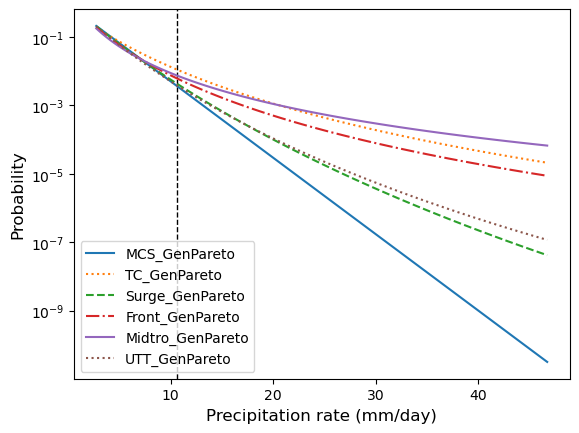

In [45]:
fig = plt.figure()
sub_precip = monsoon_precip.sel(sub_id=6)
sub_precip = sub_precip[sub_precip>1]
plt.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
print(len(two_way_precip))
x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
precip_list = [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip]
for i, precip in enumerate(precip_list):
    if len(precip) > 10:
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(names[i], a1, scale1)
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(names[i], a2, scale2)
        plt.plot(x, pdf, label=names[i]+'_'+dis, linestyle=linestyle_str[i%4])
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precipitation rate (mm/day)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.savefig('Sub6-1.png', dpi=200, bbox_inches='tight')
plt.show()

15
TC_UTT (0.2736511341348577, 2.0567452998101015)
TC_mcs (0.9999999981236698, 4.250363970399654)
TC_surge (0.9999999999293336, 3.4543298569805856)
TC_front (0.9999999999579148, 7.00528345362479)
UTT_MCS (0.0003889466812997926, 1.929113511387186)
UTT_Surge (0.04979921319440611, 1.8496957287625366)
UTT_Midtro (0.4899096257211762, 1.5231357330425874)
UTT_Front (0.2676046503351848, 1.5401023542412036)
MCS_Front (0.010087295225987909, 1.8655007789374594)
MCS_Surge (0.9999999986611183, 2.0554403481337005)
Midtro_Front (0.21754308865175093, 1.7635282488395658)
Midtro_Surge (0.2789712717011881, 1.841751735696278)
Front_Surge (0.208450350590249, 1.8258285580204014)


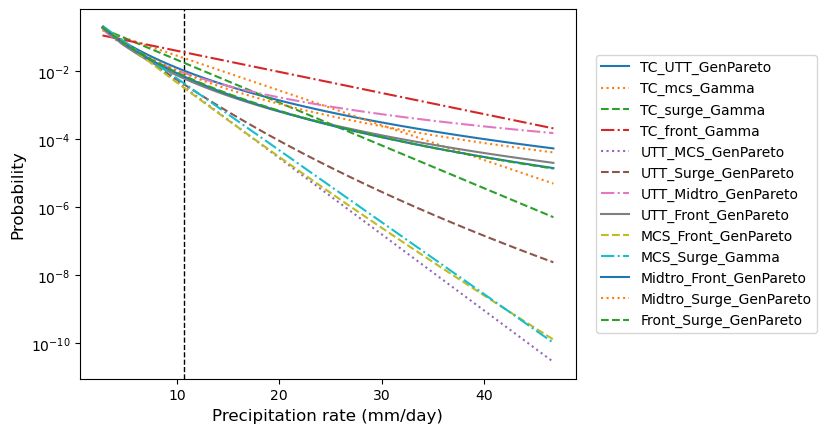

In [46]:
fig = plt.figure()
sub_precip = monsoon_precip.sel(sub_id=6)
sub_precip = sub_precip[sub_precip>1]
plt.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
print(len(two_way_precip))
x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
for i, precip in enumerate(two_way_precip[:]):
    if len(precip) > 10:
        # print(two_way_names[i])
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(two_way_names[i], (a1, scale1))
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(two_way_names[i], (a2, scale2))
        two_way_params_gp[two_way_names[i]] = (a2, scale2)
        two_way_params_ga[two_way_names[i]] = (a1, scale1)
        plt.plot(x, pdf, label=two_way_names[i]+'_'+dis, linestyle=linestyle_str[i%4])


plt.legend(loc='right', ncol=1, bbox_to_anchor=(1.5, .5))
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precipitation rate (mm/day)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.savefig('Sub6-2.png', dpi=200, bbox_inches='tight')
plt.show()

In [47]:
precip_list = [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip]
CDF_Function(6, two_way_precip, precip_list)

TOTAL:  2466
TC_UTT 21
TC_UTT (0.2736511341348577, 2.0567452998101015) 0.04891711088716966 21
TC_mcs 15
TC_mcs (0.9999999981236698, 4.250363970399654) 0.10332315375401113 15
TC_surge 84
TC_surge (0.9999999999293336, 3.4543298569805856) 0.06123844130369882 84
TC_front 15
TC_front (0.9999999999579148, 7.00528345362479) 0.252276815632569 15
TC_midtro 10
TC_midtro (0.9999999978914678, 2.2590207387802934) 0.01397029919898407 10
UTT_MCS 307
UTT_MCS (0.0003889466812997926, 1.929113511387186) 0.006762665717223948 307
UTT_Surge 697
UTT_Surge (0.04979921319440611, 1.8496957287625366) 0.009687973915855519 697
UTT_Midtro 22
UTT_Midtro (0.4899096257211762, 1.5231357330425874) 0.05604018195406535 22
UTT_Front 172
UTT_Front (0.2676046503351848, 1.5401023542412036) 0.02525270890358633 172
MCS_Midtro 6
MCS_Midtro (0.99999999649177, 2.6896264736682918) 0.02767934979704656 6
MCS_Front 223
MCS_Front (0.010087295225987909, 1.8655007789374594) 0.0064650248210395 223
MCS_Surge 393
MCS_Surge (0.99999999866111

10.647874758983226


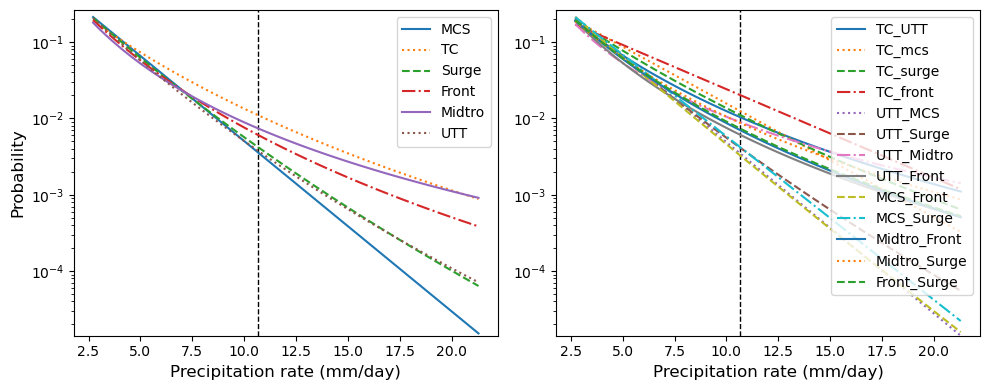

In [48]:
plot(sub_id=6, save=True)

# Sub7

tutt
Midtro
front
surge
tc
mcs


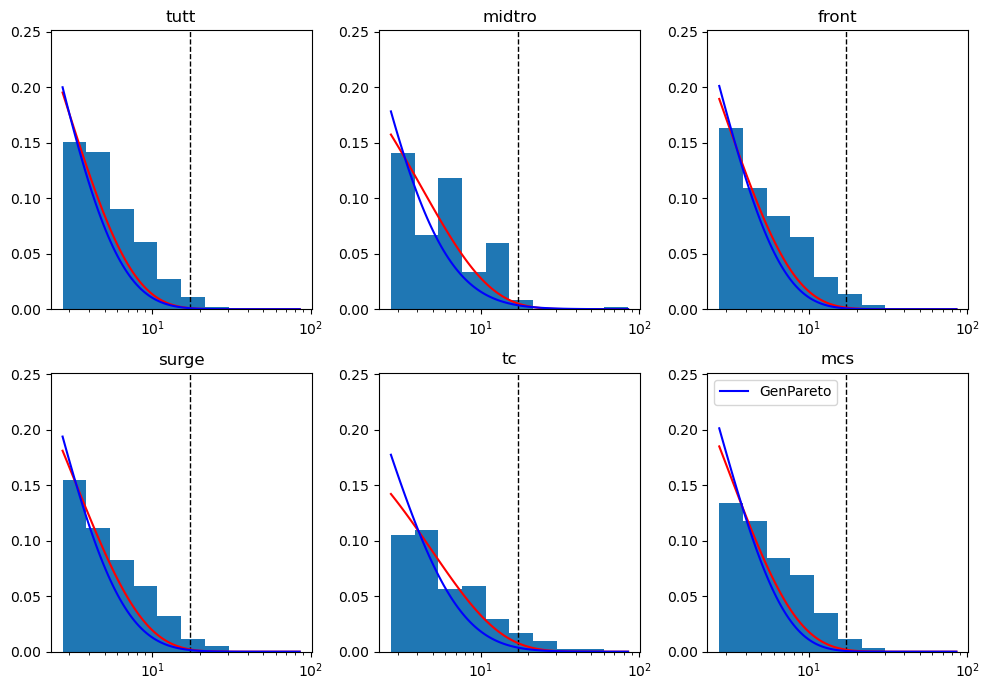

In [49]:
[mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
[param_mcs_ga, param_tc_ga, param_surge_ga, param_front_ga, param_midtro_ga, param_tutt_ga], \
[param_mcs_gp, param_tc_gp, param_surge_gp, param_front_gp, param_midtro_gp, param_tutt_gp], \
two_way_precip = plot_sub(sub_id=7, dis_type='gamma')

15
TC_UTT (0.9999999995601379, 5.487572962105412)
TC_mcs (0.9999999996039917, 4.278395258761658)
TC_surge (0.9999999994789568, 5.025020049599588)
TC_front (0.9999999998221767, 6.070035076122592)
UTT_MCS (0.9999999942294413, 2.902414320730646)
UTT_Surge (0.9999999984768106, 3.214945270484912)
UTT_Front (0.9999999918862638, 2.4135987247804107)
MCS_Front (0.9999999977084928, 3.2932557777121136)
MCS_Surge (0.999999999719366, 3.5598069373287924)
Midtro_Surge (0.3481209544927557, 2.543794144813438)
Front_Surge (0.9999999995911513, 3.2488414429544985)
MCS 0.9999999964922286 3.1114400837146423
TC 0.9999999994542387 4.983733360077345
Surge 0.999999998149357 3.2589404992997886
Front 0.999999949725197 2.9443830371693283
Midtro 0.32397720974348654 2.3647053597236427
UTT 0.9999999995075348 2.7293124017147


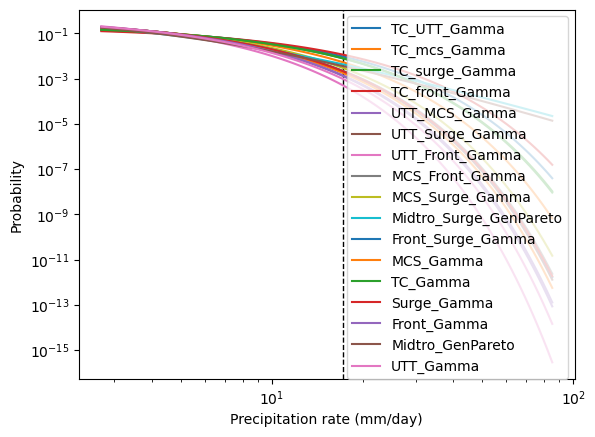

In [50]:
two_way_params_gp = {}
two_way_params_ga = {}
fig = plt.figure()
sub_precip = monsoon_precip.sel(sub_id=7)
sub_precip = sub_precip[sub_precip>1]
plt.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
print(len(two_way_precip))
x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
for i, precip in enumerate(two_way_precip[:]):
    if len(precip) > 10:
        # print(two_way_names[i])
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(two_way_names[i], (a1, scale1))
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(two_way_names[i], (a2, scale2))
        two_way_params_gp[two_way_names[i]] = (a2, scale2)
        two_way_params_ga[two_way_names[i]] = (a1, scale1)
        plt.plot(x, pdf, label=two_way_names[i]+'_'+dis)
precip_list = [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip]
for i, precip in enumerate(precip_list):
    if len(precip) > 10:
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(names[i], a1, scale1)
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(names[i], a2, scale2)
        plt.plot(x, pdf, label=names[i]+'_'+dis)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precipitation rate (mm/day)')
plt.ylabel('Probability')
plt.show()

15
MCS 0.9999999964922286 3.1114400837146423
TC 0.9999999994542387 4.983733360077345
Surge 0.999999998149357 3.2589404992997886
Front 0.999999949725197 2.9443830371693283
Midtro 0.32397720974348654 2.3647053597236427
UTT 0.9999999995075348 2.7293124017147


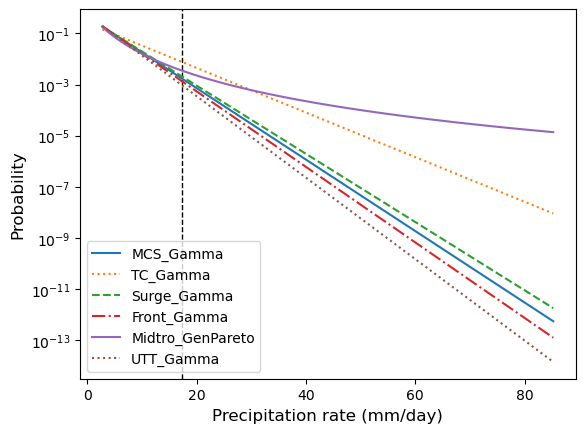

In [51]:
fig = plt.figure()
sub_precip = monsoon_precip.sel(sub_id=7)
sub_precip = sub_precip[sub_precip>1]
plt.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
print(len(two_way_precip))
x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
precip_list = [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip]
for i, precip in enumerate(precip_list):
    if len(precip) > 10:
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(names[i], a1, scale1)
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(names[i], a2, scale2)
        plt.plot(x, pdf, label=names[i]+'_'+dis, linestyle=linestyle_str[i%4])
plt.legend()
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precipitation rate (mm/day)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.savefig('Sub7-1.png', dpi=200, bbox_inches='tight')
plt.show()

15
TC_UTT (0.9999999995601379, 5.487572962105412)
TC_mcs (0.9999999996039917, 4.278395258761658)
TC_surge (0.9999999994789568, 5.025020049599588)
TC_front (0.9999999998221767, 6.070035076122592)
UTT_MCS (0.9999999942294413, 2.902414320730646)
UTT_Surge (0.9999999984768106, 3.214945270484912)
UTT_Front (0.9999999918862638, 2.4135987247804107)
MCS_Front (0.9999999977084928, 3.2932557777121136)
MCS_Surge (0.999999999719366, 3.5598069373287924)
Midtro_Surge (0.3481209544927557, 2.543794144813438)
Front_Surge (0.9999999995911513, 3.2488414429544985)


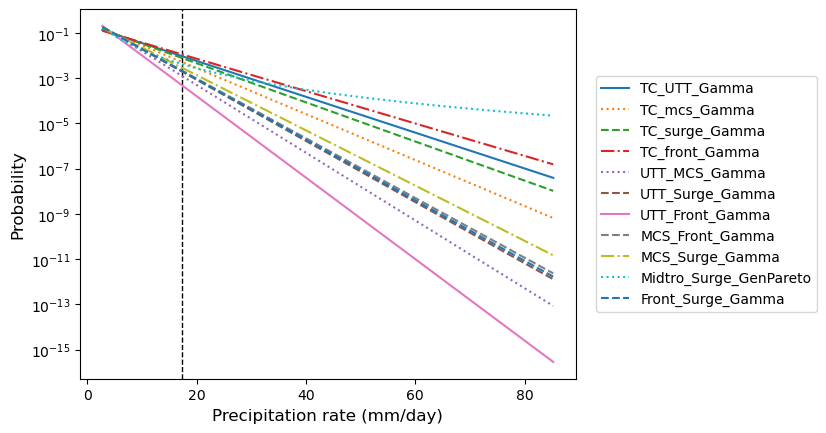

In [52]:
fig = plt.figure()
sub_precip = monsoon_precip.sel(sub_id=7)
sub_precip = sub_precip[sub_precip>1]
plt.axvline(np.quantile(sub_precip, .95), color='k', linestyle='dashed', linewidth=1)
print(len(two_way_precip))
x = np.logspace(1, np.log(np.max(sub_precip.data)), num=100, base=np.e)
for i, precip in enumerate(two_way_precip[:]):
    if len(precip) > 10:
        # print(two_way_names[i])
        (a1, scale1), (a2, scale2), pdf_max, (score_ga, score_gp) = fit_gamma_genpareto(precip, None, x)
        if score_ga<score_gp:
            pdf = gamma.pdf(x, a1, 0, scale1)/(1-gamma.cdf(1, a1, 0, scale1))
            dis = 'Gamma'
            print(two_way_names[i], (a1, scale1))
        else:
            pdf = genpareto.pdf(x, a2, 1, scale2)
            dis = 'GenPareto'
            print(two_way_names[i], (a2, scale2))
        two_way_params_gp[two_way_names[i]] = (a2, scale2)
        two_way_params_ga[two_way_names[i]] = (a1, scale1)
        plt.plot(x, pdf, label=two_way_names[i]+'_'+dis, linestyle=linestyle_str[i%4])


plt.legend(loc='right', ncol=1, bbox_to_anchor=(1.5, .5))
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Precipitation rate (mm/day)', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.savefig('Sub7-2.png', dpi=200, bbox_inches='tight')
plt.show()

In [53]:
precip_list = [mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip]
CDF_Function(7, two_way_precip, precip_list)

TOTAL:  3048
TC_UTT 50
TC_UTT (0.9999999995601379, 5.487572962105412) 0.05172903915588467 50
TC_mcs 50
TC_mcs (0.9999999996039917, 4.278395258761658) 0.02239776735102894 50
TC_surge 160
TC_surge (0.9999999994789568, 5.025020049599588) 0.03938525948117566 160
TC_front 14
TC_front (0.9999999998221767, 6.070035076122592) 0.06873224787078147 14
TC_midtro 9
TC_midtro (0.6409132433521397, 2.3520005782939677) 0.07139338130110695 9
UTT_MCS 398
UTT_MCS (0.9999999942294413, 2.902414320730646) 0.0036988549982657215 398
UTT_Surge 400
UTT_Surge (0.9999999984768106, 3.214945270484912) 0.006374998928721953 400
UTT_Midtro 7
UTT_Midtro (0.9999999999113304, 4.104624189823931) 0.019070405235565357 7
UTT_Front 95
UTT_Front (0.9999999918862638, 2.4135987247804107) 0.0011899771189950448 95
MCS_Midtro 3
MCS_Front 194
MCS_Front (0.9999999977084928, 3.2932557777121136) 0.007189314816248071 194
MCS_Surge 351
MCS_Surge (0.999999999719366, 3.5598069373287924) 0.010403378934002672 351
Midtro_Front 1
Midtro_Surge 1

17.252742222601025


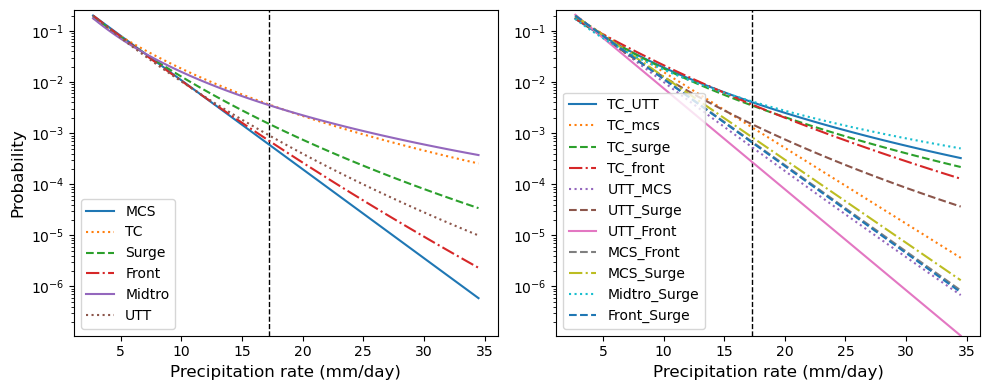

In [54]:
plot(sub_id=7, save=True)

# MLE

* Maximum negative loglikelihood function: -sum(log pdf(x, theta), axis=0) + penalty
* Gamma distribution:   ${\text{pdf}(y, a)}/{scale} = \text{pdf}(x, a, loc, scale)$, where $y = (x-loc)/scale$
* Gamma pdf: $f(x, a)=\frac{x^{a-1}e^{-x}}{\Gamma(a)}$
* 3 parameters: $$f(x, a, loc, scale)=f(y, a)/scale$$
$$=\frac{y^{a-1}e^{-y}}{\Gamma(a)}/scale$$

In [55]:
init_c = 0
init_loc = 1
init_scale = 10


In [56]:
print(gamma.a)
print(gamma.b)
_XMAX = np.finfo(float).max
print(_XMAX)

0.0
inf
1.7976931348623157e+308


tutt
Midtro
front
surge
mcs


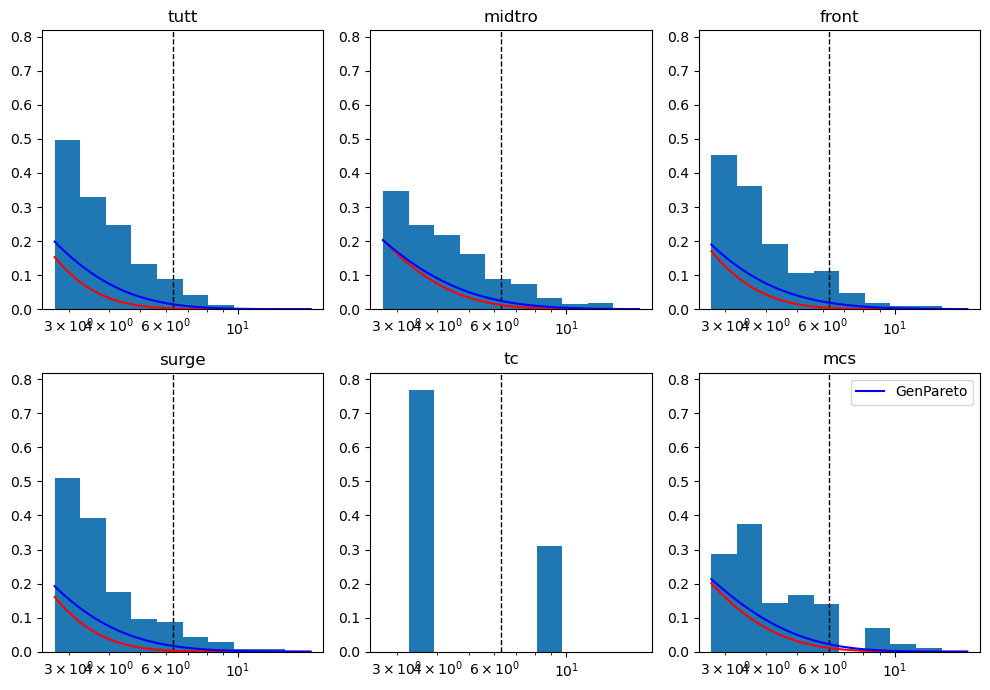

ValueError: too many values to unpack (expected 3)

In [57]:
[mcs_precip, tc_precip, surge_precip, front_precip, midtro_precip, tutt_precip], \
[param_mcs_ga, param_tc_ga, param_surge_ga, param_front_ga, param_midtro_ga, param_tutt_ga], \
[param_mcs_gp, param_tc_gp, param_surge_gp, param_front_gp, param_midtro_gp, param_tutt_gp] = plot_sub(sub_id=4, dis_type='gamma')

In [ ]:
print(np.array(tc_precip).flatten())
print(param_tc_gp)

In [ ]:
for i in range(1, 8):
    sub_precip = monsoon_precip.sel(sub_id=i)
    sub_precip = sub_precip[sub_precip>1]
    print(np.quantile(sub_precip, .95), i)